#### Shim Kyu Gong (심 규 공)

 * **1. Introduction**
  * 1.1 Feature Analysis
  * 1.2 Feature Engineering
 * **2. Load Data**
 * **3. Data Cleaning**
  * 3.1 필요한 Columns 가져오기
  * 3.2 Gender 정리
  * 3.3 Height 정리
  * 3.4 Age 정리
 * **4. Find VIP**
  * 4.1 필요한 Columns 가져오기
  * 4.2 BMI Caculate From Columns With Additional Information
  * 4.3 Find Invalid user
    * 4.3.1 Noom 구매자(Status == "completed")
    * 4.3.2 나이, 키, 몸무게 중 NaN 포함
    * 4.3.3 키(140 cm 미만), 혹은 (200 cm 초과) 기입 가입자
    * 4.3.4 BMI (18.5 미만), 혹은 (30.0 초과)
    * 4.3.5 목표 감량치 마이너스인 경우
  * 4.4 VIP 사용자 확인
    * 4.4.1 Noom 구매자(Status == "completed")
    * 4.4.2 나이, 키, 몸무게 중 NaN 미포함
    * 4.4.3 최종 감량치(Weight Loss(current)) 10kg 이상
    * 4.4.4 BMI 수치 높은 사용자(30.0 초과)
    * 4.4.5 최종 감량치(Weight Loss(current))가 목표 감량치(Weight Loss(goal))보다 큰경우(Diet 성공)
    * 4.4.6 VIP 마케팅 list (extra list)
 * **5. 결제 확인**
  * 5.1 Costomer Acquision Cost(CAC)
  * 5.2 Customer Lifetime Value(CLV)
  * 5.3 completed/cancelled/refunded value counts
  * 5.4 Gender and Age(completed/cancelled/refunded)
     * 5.4.1 Visualization(Age(Group)), Status with Age(clean)
  * 5.5 Weekday and Time(completed/cancelled/refunded)
     * 5.5.1 Visualization(Weekday and Time)
  * 5.6 Channel(completed/cancelled/refunded) with Visualization
  * 5.7 Gender(clean)과 Age(Group)의 Channel 별 completed 현황   
  * 5.8 현 사용자의 Initial Weight으로 미래 고객층 마케팅 타켓 찾기   
 * **6. Matching With Coach Data**
  * 6.1 데이터 합치기(기존 + 코치)
  * 6.2 코치별 담당 Counts(total/coompleted/cancelled/refunded)
  * 6.3 코치별 Rate(conversion/cancellation)

## 1. Introduction

눔(Noom)과 같이 데이터에 기반한 의사결정으로 일 하는 스타트업에서 데이터 분석가(Data Analyst)의 역할은 매우 중요합니다. 가령 눔의 마케팅 팀은 데이터 분석가(Data Analyst)의 분석 결과를 바탕으로 페이스북 광고 채널의 예산을 재조정(rebalancing)할 수 있습니다. 운영팀은 데이터 분석가(Data Analyst)가 찾아낸 VIP고객에게 혜택을 제공해줌으로서 그들이 계속 서비스를 이용하게 할 수 있습니다. 코칭 팀은 데이터 분석가(Data Analyst)가 분석한 고객의 코칭 만족도를 바탕으로 코칭 방침을 개선할 수 있습니다.

  * 1.1 Feature Analysis
  * 1.2 Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats#시각화시 흐린 폰트 선명하게 

matplotlib.rc('font', family='Malgun Gothic') # 한글 폰트

matplotlib.rc('axes', unicode_minus=False) # 마이너스 값도 표현
set_matplotlib_formats('retina')

## 2. Load Data
판다스(Pandas)의 read_csv 라는 기능을 사용하여 데이터 로딩

In [2]:
# noom_user.csv 파일을 읽어와 data라는 이름의 변수에 할당.
# 사용자의 프로필(성별, 나이 등)과 구매 정보 등 포함.
# 또한 이 과정에서 구매 날짜(Purchased At)는 별도로 날짜 컬럼으로 해석할 수 있게 parse_dates 옵션에 추가합니다.

data = pd.read_csv("C:/Users/kyugs/Desktop/titanic/noom/transaction/transaction/noom_user.csv", parse_dates=["Purchased At"])

# 컬럼명 출력.
print(data.columns)

# data 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)

data.head()

Index(['Access Code', 'Name', 'Gender', 'Age', 'Height', 'Initial Weight',
       'Lowest Weight', 'Target Weight', 'Product Name', 'Status', 'Price',
       'Purchased At', 'Payment Type', 'Channel'],
      dtype='object')
(10000, 14)


,Access Code,Name,Gender,Age,Height,Initial Weight,Lowest Weight,Target Weight,Product Name,Status,Price,Purchased At,Payment Type,Channel
0,Y9RY2VSI,김승혜,FEMALE,25.0,172.0,66.9,65.8,55.000000,눔 체중감량 프로그램,completed,112500,2017-04-14 19:03:29.976,Recurring,others
1,3GTN3S3B,허승준,MALE,26.0,176.0,70.0,NaN,65.000000,눔 체중감량 프로그램,completed,44780,2017-05-23 20:53:54.368,Recurring,others
2,6B0IG276,이지민,FEMALE,23.0,171.0,98.0,NaN,91.140000,눔 체중감량 프로그램 (천원 체험),completed,132000,2017-08-23 23:39:21.840,Recurring,facebook
3,EMGRU2MO,장설윤,FEMALE,20.0,160.0,70.7,NaN,53.000000,눔 체중감량 프로그램 (천원 체험),completed,112500,2017-08-28 20:18:22.824,Recurring,naver
4,1ELG96TX,서성빈,FEMALE,28.0,165.0,55.5,NaN,51.615002,눔 체중감량 프로그램,completed,44780,2017-05-07 17:50:30.944,Recurring,facebook


컬럼에 대한 설명은 다음과 같습니다.

  * **Access Code** - 고객의 접근 코드, 쉽게 말해 고객을 식별할 수 있는 정보라고 보면 됩니다.
  * **Name** - 고객의 이름입니다. 한글로 되어있습니다.
  * **Gender** - 고객의 성별입니다. MALE과 FEMALE, 그리고 빈 값(NaN)으로 되어있습니다.
  * **Age** - 고객의 나이입니다.
  * **Height** - 고객의 키입니다. cm 기준입니다.
  * **Initial Weight** - 고객이 처음 눔 코치에 회원 가입 했을 당시의 몸무게입니다. kg 기준입니다.
  * **Lowest Weight** - 고객이 눔 코치를 이용하는 동안 측정한 몸무게 중, 가장 낮은 몸무게입니다. kg 기준입니다.
  * **Target Weight** - 고객이 눔 코치를 처음 회원 가입할 때 설정한 목표 몸무게입니다. kg 기준입니다.
  * **Product Name** - 눔 코치 프로그램의 상세 제품명입니다.
  * **Status** - 고객의 유료 서비스 결제 현황입니다. 결제중(complete), 결제 취소(cancelled), 환불 완료(refunded)로 되어있습니다.
  * **Price** - 서비스를 구입할 당시의 가격입니다. 원(₩) 기준입니다.
  * **Purchased At** - 서비스를 구입할 당시의 시간입니다.
  * **Payment Type** - 결제 방식입니다. 현재는 Recurring(구독형 결제)만 있습니다.
  * **Channel** - 서비스 구입 경로입니다. 구글, 페이스북, 네이버 등 다양한 경로를 통해 서비스를 구입하고 있습니다.
  


## 3. Data Cleaning

먼저 눔(Noom)의 데이터에서 정리가 필요한 몇몇 부분을 다뤄보겠습니다.

  * **3.1 필요한 Columns 가져오기**

사용하지 않는 컬럼을 사전에 정리

In [3]:
# 필요 columns 사전 정리.

columns=["Access Code", "Name", "Gender", "Age", "Height", "Initial Weight", 
         "Lowest Weight", "Target Weight", "Status", "Price", "Purchased At", 
         "Channel"]

data = data[columns]

# "Access Code"를 Index로 지정.
data = data.set_index("Access Code")

# data 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)
data.head()

(10000, 11)


,Name,Gender,Age,Height,Initial Weight,Lowest Weight,Target Weight,Status,Price,Purchased At,Channel
Access Code,,,,,,,,,,,
Y9RY2VSI,김승혜,FEMALE,25.0,172.0,66.9,65.8,55.000000,completed,112500,2017-04-14 19:03:29.976,others
3GTN3S3B,허승준,MALE,26.0,176.0,70.0,NaN,65.000000,completed,44780,2017-05-23 20:53:54.368,others
6B0IG276,이지민,FEMALE,23.0,171.0,98.0,NaN,91.140000,completed,132000,2017-08-23 23:39:21.840,facebook
EMGRU2MO,장설윤,FEMALE,20.0,160.0,70.7,NaN,53.000000,completed,112500,2017-08-28 20:18:22.824,naver
1ELG96TX,서성빈,FEMALE,28.0,165.0,55.5,NaN,51.615002,completed,44780,2017-05-07 17:50:30.944,facebook


* **3.2 Gender 정리**

In [4]:
# 성별(Gender) 컬럼에서 중복된 값을 제거합니다.
# 최종적으로 성별 컬럼의 종류가 나옵니다. (nan은 Not a Number, 즉 값이 없다는 의미입니다)
data["Gender"].unique()

array(['FEMALE', 'MALE', nan], dtype=object)

가독성을 높이기 위해, FEMALE은 female로, MALE은 male로 변경.
```Gender``` 컬럼이 아닌 ```Gender(clean)```이라는 새로운 컬럼 생성.

```Gender``` 컬럼을 정리 뒤, 전체 가입자중 남성의 비율과 여성의 비율을 계산

In [5]:
# data.loc[data["Gender"] == "FEMALE", "Gender(clean)"] = "female"
# data.loc[data["Gender"] == "MALE", "Gender(clean)"] = "male"
# data[["Gender", "Gender(clean)"]].head()

data["Gender(clean)"] = data["Gender"].replace({"FEMALE":"female", "MALE":"male"})

# data 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)
data[["Gender", "Gender(clean)"]].head()

(10000, 12)


,Gender,Gender(clean)
Access Code,,
Y9RY2VSI,FEMALE,female
3GTN3S3B,MALE,male
6B0IG276,FEMALE,female
EMGRU2MO,FEMALE,female
1ELG96TX,FEMALE,female


In [6]:
# 전체 가입자중 남성의 비율과 여성의 비율

data["Gender(clean)"].value_counts()

female    8846
male      1023
Name: Gender(clean), dtype: int64

* **3.3 Height 정리**

```Height``` 컬럼도 성별 컬럼과 같이 정리.
1) 최소/최대/평균 키를 구하고, 2) 남성/여성별 평균 키를 구함.

In [7]:
# Height 컬럼에서 가장 작은(min) 값을 찾아와서 출력.
data["Height"].min()

-1.0

* 키 -1.0 cm인 사람은 존재하지 않음.
* 가능성 : 가입자 혹은 데이터 담당자에 의해서 NaN이 아닌 -1.0 으로 기입.
* 효과 : 통계치 부정확.
* 실행 : 새로운 ```Hegiht(clean)``` 설정하여, -1.0를 NaN으로 데이터 입력.

In [8]:
# 가장 큰 키 
data['Height'].max()

203.2

In [9]:
# 평균 키
data["Height"].mean()

163.19149457898467

In [10]:
# 원본 데이터 보존 위해, 새로운 컬럼 생성 
data["Height(clean)"] = data["Height"]

#결측치로 여겨지는 마이너스 값을 nan 값으로 변경.
data.loc[data["Height"] < 0, "Height(clean)"] = np.nan

# 변경 확인
data.loc[data["Height"] < 0, ["Height", "Height(clean)"]].head()

,Height,Height(clean)
Access Code,,
O4OWMJG7,-1.0,NaN
H6EV5AXL,-1.0,NaN
O1IAZS7A,-1.0,NaN
5NEQOWHW,-1.0,NaN
OFAXUNXD,-1.0,NaN


In [11]:
data["Height(clean)"].min()

106.0

In [12]:
data["Height(clean)"].max()

203.2

In [13]:
data["Height(clean)"].mean()

163.54161860276196

In [14]:
# 혹은 .describe() 을 통해 한눈에 데이터 최소, 최대, 평균을 볼수있음
data["Height(clean)"].describe()

count    9848.000000
mean      163.541619
std         6.828374
min       106.000000
25%       159.000000
50%       163.000000
75%       167.000000
max       203.200000
Name: Height(clean), dtype: float64

* **3.4 Age 정리**

3.3과 비슷한 이유로, 나이(```Age```) 컬럼도 정리
1) 최소/최대/평균 나이, 2) 남성/여성별 평균 나이

In [15]:
# 가장 나이가 어린 고객을 찾습니다.
# min 결과는 0세라고 나오지만, 0세 사용자가 이 서비스를 사용할 가능성은 없습니다.
# 즉, 이 데이터는 잘못 기입된 데이터라고 판단 가능
# max 결과는 173세라고 나오는데, 이 데이터도 잘못 기입되었다고 판단할 수 있습니다.
data["Age"].describe()

count    9869.000000
mean       27.463573
std         7.376082
min         0.000000
25%        23.000000
50%        26.000000
75%        31.000000
max       173.000000
Name: Age, dtype: float64

나이 컬럼을 정리해줄 필요. 다음의 규칙에 맞춰서 나이 컬럼을 정리.

  * 나이가 0인 데이터는 NaN으로 변경
  * 나이가 60세 이상인 데이터는 NaN으로 변경

In [16]:
# 원본 데이터 보존 위해, 새로운 컬럼 생성
data["Age(clean)"] = data["Age"]

#결측치로 여겨지는 마이너스 값을 nan 값으로 변경.
data.loc[data["Age(clean)"] == 0, "Age(clean)"] = np.nan
data.loc[data["Age(clean)"] >= 60, "Age(clean)"] = np.nan

# 변경 확인
data.loc[(data["Age"] == 0) | (data["Age"] >= 60), ["Age", "Age(clean)"]].head()

,Age,Age(clean)
Access Code,,
9PTGVW4B,0.0,NaN
ACV6D35S,0.0,NaN
Y0OK1FWA,85.0,NaN
WX34HGBL,0.0,NaN
R9XCS81F,0.0,NaN


In [17]:
# .describe()으로 바뀐 수치 확인.
data["Age(clean)"].describe()

count    9855.000000
mean       27.393810
std         6.545051
min        13.000000
25%        23.000000
50%        26.000000
75%        31.000000
max        59.000000
Name: Age(clean), dtype: float64

In [18]:
# pandas의 pivot_table을 이용 하여 남/녀 나이 평균을 확인.
pd.pivot_table(data, index="Gender(clean)", values="Age(clean)")

,Age(clean)
Gender(clean),
female,27.172929
male,29.309127


## 4. Find VIP

데이터 정리 후, 본격적 데이터 분석(Data Analysis) 시작.

1. 유료 사용자 중, 사용자 정보를 잘못 기입한 사람
2. 유료 사용자 중, 눔 코치의 VIP 사용자라고 간주할 수 있는 사람

1번 사용자의 경우, 유료결제 시, 사용자 정보(나이, 키, 몸무게 등)가 잘못 기입 경우 담당 코치가 정확한 코칭 제공 불가능. 정보를 잘못 기입한 고객을 찾아 다시 기입 요청.

2번 사용자의 경우, 눔의 VIP 사용자로서 추가 혜택(ex: 서비스 무료 이용)을 제공해주는 것을 조건으로, 눔 코치를 대표하는 홍보 모델 활동 요청.

소비자 관점에서 다이어트 관련 서비스는 VIP 사용자의 Before / After는 최고 홍보 마케팅 수단. 그러므로 데이터 분석 팀에서 특정 조건(ex: 10kg 이상 감량 성공)에 만족하는 코어 사용자 찾는 것 중요.

정리된 데이터를 활용, 1) 잘못된 정보를 기입한 사용자(invalid user)와, 눔 코치를 사용하여 큰 성과(ex: 몸무게 감량)를 본 사용자(VIP user)를 찾음.

**4.1 필요한 Columns 가져오기**

이번 데이터 분석에서 필요한 컬럼 정리

```Access Code```가 인덱스(Index)로 지정

In [19]:
# 필요 columns 사전 정리
columns =["Name", "Age(clean)", "Height(clean)", "Initial Weight", 
          "Lowest Weight", "Target Weight", "Status"]

# 기존 컬럼을 보존 하기 위해, 새로운 컬럼에 .copy() 설정함.
data_weight = data[columns].copy()

# data_weight 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data_weight.shape)
data_weight.head()

(10000, 7)


,Name,Age(clean),Height(clean),Initial Weight,Lowest Weight,Target Weight,Status
Access Code,,,,,,,
Y9RY2VSI,김승혜,25.0,172.0,66.9,65.8,55.000000,completed
3GTN3S3B,허승준,26.0,176.0,70.0,NaN,65.000000,completed
6B0IG276,이지민,23.0,171.0,98.0,NaN,91.140000,completed
EMGRU2MO,장설윤,20.0,160.0,70.7,NaN,53.000000,completed
1ELG96TX,서성빈,28.0,165.0,55.5,NaN,51.615002,completed


**4.2 BMI With Additional Information.**

잘못된 정보를 기입한 사용자와 VIP 사용자를 구분 위한 컬럼 새로 추가. 

다음의 세 가지 정보를 담은 컬럼을 추가해주세요.

  1. ```Weight Loss(goal)``` - 목표 감량치. ```Initial Weight``` 컬럼과 ```Target Weight```의 차이를 나냄. (마이너스가 나올 수 있음)
  2. ```Weight Loss(current)``` - 최대 감량치. ```Initial Weight``` 컬럼과 ```Lowest Weight```의 차이를 나타냄. (마이너스가 나올 수 있음)
  3. 체질량지수(```BMI```) - 키(```Height(clean)```)와 체중(```Initial Weight```)으로 체지방 양 추정 공식.

$$
BMI = \frac{체중(kg)}{키(m) \times 키(m)}
$$

In [20]:
# BMI공식에서 사용하는 키는 센치미터(cm)가 아닌 미터(m)라는것에 주의(미터로 전환)
data_weight["Height(m)(clean)"] = data_weight["Height(clean)"] / 100

#목표 감량치 
data_weight["Weight Loss(goal)"] = data_weight["Initial Weight"] - data_weight["Target Weight"]

# 최대 감량치
data_weight["Weight Loss(current)"] = data_weight["Initial Weight"] - data_weight["Lowest Weight"]

# BMI 계산 공식
data_weight["BMI"] = data_weight["Initial Weight"] / (data_weight["Height(m)(clean)"] ** 2)

# data_weight 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
print(data_weight.shape)
data_weight[["Name", "Weight Loss(goal)", "Weight Loss(current)", "BMI"]].head()

(10000, 11)


,Name,Weight Loss(goal),Weight Loss(current),BMI
Access Code,,,,
Y9RY2VSI,김승혜,11.900000,1.1,22.613575
3GTN3S3B,허승준,5.000000,NaN,22.598140
6B0IG276,이지민,6.860000,NaN,33.514586
EMGRU2MO,장설윤,17.700000,NaN,27.617187
1ELG96TX,서성빈,3.884998,NaN,20.385675


In [21]:
# 컬럼 추가 확인
data_weight.head()

,Name,Age(clean),Height(clean),Initial Weight,Lowest Weight,Target Weight,Status,Height(m)(clean),Weight Loss(goal),Weight Loss(current),BMI
Access Code,,,,,,,,,,,
Y9RY2VSI,김승혜,25.0,172.0,66.9,65.8,55.000000,completed,1.72,11.900000,1.1,22.613575
3GTN3S3B,허승준,26.0,176.0,70.0,NaN,65.000000,completed,1.76,5.000000,NaN,22.598140
6B0IG276,이지민,23.0,171.0,98.0,NaN,91.140000,completed,1.71,6.860000,NaN,33.514586
EMGRU2MO,장설윤,20.0,160.0,70.7,NaN,53.000000,completed,1.60,17.700000,NaN,27.617187
1ELG96TX,서성빈,28.0,165.0,55.5,NaN,51.615002,completed,1.65,3.884998,NaN,20.385675


이제 이 세 가지 정보만 있으면, 정보를 잘못 기입한 사용자(invalid user)와 VIP 사용자를 찾아낼 수 있습니다.

**4.3 Find Invalid user**

위 4.2의 세 가지 데이터를 활용하여 잘못된 정보 기입한 사용자 찾기.(결제 구매자 안에서)
Invalid라는 이름의 새로운 컬럼에 True라는 값 설정.(반대의 경우 : False)
   * 4.3.1 Noom 구매자(Status == "completed")
   * 4.3.2 나이, 키, 몸무게 중 NaN 포함
   * 4.3.3 키(140 cm 미만), 혹은 (200 cm 초과) 기입 가입자
   * 4.3.4 BMI (18.5 미만), 혹은 (30.0 초과)
   * 4.3.5 목표 감량치 마이너스인 경우

In [22]:
# 프로그램 결제한 구매자. (Status == "completed")
# 조건 중 하나라도 만족할 경우 Invalid값에 True
# Age(clean), Height(clean)와 Initial Weight, Lowest Weight, Target Weight중 어느 하나라도 NaN이 들어가 있는 경우. 
# 키(140cm 미만)나, 반대 경우(200cm 초과) 기입한 사용자.
# BMI수치(18.5 미만)와 (30.0 초과)
# Weight Loss(goal)가 마이너스인 경우. (보통 현재 체중보다 목표 체중을 낮게 설정합니다)

def find_invalid(row):
    status = row["Status"]
    age = row["Age(clean)"]
    height = row["Height(clean)"]
    initial_weight = row["Initial Weight"]
    lowest_weight = row["Lowest Weight"]
    target_weight = row["Target Weight"]
    bmi = row["BMI"]
    weight_loss = row["Weight Loss(goal)"]
    
    if status != "completed":
        return False
    
    if pd.isnull(age) or pd.isnull(height):
        return True
    
    if height < 140 or height > 200:
        return True
    
    if pd.isnull(initial_weight) or pd.isnull(lowest_weight) or pd.isnull(target_weight):
        return True
    
    if pd.isnull(bmi) or bmi < 18.5 or bmi > 30:
        return True
    
    if pd.isnull(weight_loss) or weight_loss < 0:
        return True
    
    return False

# Invalid 컬럼 생성을 .apply()를 사용하여 기존 데이터에 추가.
data_weight["Invalid"] = data_weight.apply(find_invalid, axis = "columns")

invalid = data_weight[data_weight["Invalid"]]

# invalid 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(invalid.shape)
invalid.head()

(2619, 12)


,Name,Age(clean),Height(clean),Initial Weight,Lowest Weight,Target Weight,Status,Height(m)(clean),Weight Loss(goal),Weight Loss(current),BMI,Invalid
Access Code,,,,,,,,,,,,
3GTN3S3B,허승준,26.0,176.0,70.0,NaN,65.000000,completed,1.76,5.000000,NaN,22.598140,True
6B0IG276,이지민,23.0,171.0,98.0,NaN,91.140000,completed,1.71,6.860000,NaN,33.514586,True
EMGRU2MO,장설윤,20.0,160.0,70.7,NaN,53.000000,completed,1.60,17.700000,NaN,27.617187,True
1ELG96TX,서성빈,28.0,165.0,55.5,NaN,51.615002,completed,1.65,3.884998,NaN,20.385675,True
U9AELHAT,배소정,22.0,161.0,76.0,NaN,48.000000,completed,1.61,28.000000,NaN,29.319856,True


In [23]:
# 코드가 너무길어 지면 dummy를 만들어 확인 하며 미리미리 확인.

dummy = {
    "Status":"completed",
    "Age(clean)": 35,
    "Height(clean)":167,
    "Initial Weight":80,
    "Lowest Weight":60,
    "Target Weight":60,
    "BMI":20,
    "Weight Loss(goal)":-10,
}
find_invalid(dummy)

True

2619명의 사용자에게 사용자 정보 업데이트 별도 공지 메시지 가능.
운영팀이 더 효율적으로 업무 가능. 

**4.4 VIP 사용자 확인**

VIP 사용자 확인. 조건에 해당 이용자는 VIP 고객으로 간주, ```VIP```새로운 컬럼에 True 값 기입. (정 반대 경우 False)

 * 4.4.1 Noom 구매자(Status == "completed")
    * 4.4.2 나이, 키, 몸무게 중 NaN 미포함
    * 4.4.3 최종 감량치(Weight Loss(current)) 10kg 이상
    * 4.4.4 BMI 수치 높은 사용자(30.0 초과)
    * 4.4.5 최종 감량치(Weight Loss(current))가 목표 감량치(Weight Loss(goal))보다 큰경우(Diet 성공)

In [24]:
# 눔의 프로그램을 결제한 구매자. (```Status == "completed"```)
# Weight Loss(goal), Weight Loss(current), BMI 수치 모두 NaN이 아닌 값이 들어가 있는 사용자.
# Weight Loss(current)가 10kg 이상.
# BMI 수치 높은 사용자. (30.0 이상)
# Weight Loss(current)가 Weight Loss(goal)보다 큰 경우. (다이어트에 성공한 고객)

def find_vip(row):
    status = row["Status"]
    weight_loss = row["Weight Loss(goal)"]
    weight_loss_current = row["Weight Loss(current)"]
    bmi = row["BMI"]
    
    if status != "completed":
        return False
    
    if pd.isnull(weight_loss) or pd.isnull(weight_loss_current) or pd.isnull(bmi):
        return False
    if weight_loss_current <= 10:
        return False
    if bmi <= 30:
        return False
    if weight_loss_current >= weight_loss:
        return True
    
    return False

# VIP 컬럼 생성을 .apply()를 사용하여 기존 데이터에 추가.
data_weight["VIP"] = data_weight.apply(find_vip, axis = "columns")

vip = data_weight[data_weight["VIP"]]

# vip 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(vip.shape)
vip
    

(15, 13)


,Name,Age(clean),Height(clean),Initial Weight,Lowest Weight,Target Weight,Status,Height(m)(clean),Weight Loss(goal),Weight Loss(current),BMI,Invalid,VIP
Access Code,,,,,,,,,,,,,
3T1I8I8E,임솔지,23.0,158.0,80.0137,54.5,77.745742,completed,1.58,2.267958,25.5137,32.051634,True,True
PJYKU9OW,홍윤오,31.0,174.0,99.9000,76.6,84.000000,completed,1.74,15.900000,23.3000,32.996433,True,True
0EMTSGLJ,류선정,34.0,167.0,86.0000,73.2,80.050003,completed,1.67,5.949997,12.8000,30.836531,True,True
FBEAIFW0,서서원,23.0,170.0,95.0000,75.7,85.000000,completed,1.70,10.000000,19.3000,32.871972,True,True
8QQV2YDW,홍서율,23.0,170.0,95.0000,75.7,85.000000,completed,1.70,10.000000,19.3000,32.871972,True,True
99KOLRU8,고서연,26.0,162.0,106.0000,95.2,98.580000,completed,1.62,7.420000,10.8000,40.390184,True,True
IBOWZ9WZ,손서애,22.0,166.0,83.0000,66.1,73.000000,completed,1.66,10.000000,16.9000,30.120482,True,True
6EH2LGR5,문세영,34.0,164.0,88.8000,56.3,82.584003,completed,1.64,6.215997,32.5000,33.016062,True,True
QQLYGTWD,황수윤,26.0,165.0,105.0000,87.8,97.650000,completed,1.65,7.350000,17.2000,38.567493,True,True


분석 결과 위 15명의 VIP 사용자 발견. 
* 홍보팀: 위 VIP들에게 개별적으로 컨택, 눔 코치를 더 만족스럽게 이용할 수 있는 각종 혜택을 조건으로, 홍보모델 활동 제안 가능.

* 위 사용자들 제안 거절 대비, 조건을 완화한 VIP 사용자(최종 감량치(```Weight Loss(current)```)가 10kg -> 7kg 이상)를 찾아 활동 제안 염두.

* 4.4.6 VIP 마케팅 list (extra list) VIP = 15명 , VIP2 = 20명

In [25]:
# 눔의 프로그램을 결제한 구매자. (```Status == "completed"```)
# Weight Loss(goal), Weight Loss(current), BMI 수치 모두 NaN이 아닌 값이 들어가 있는 사용자.
# Weight Loss(current)가 7kg 이상.
# BMI 수치 높은 사용자. (30.0 이상)
# Weight Loss(current)가 Weight Loss(goal)보다 큰 경우. (다이어트에 성공한 고객)

def find_vip2(row):
    status = row["Status"]
    weight_loss = row["Weight Loss(goal)"]
    weight_loss_current = row["Weight Loss(current)"]
    bmi = row["BMI"]
    
    if status != "completed":
        return False
    
    if pd.isnull(weight_loss) or pd.isnull(weight_loss_current) or pd.isnull(bmi):
        return False
    if weight_loss_current <= 7:
        return False
    if bmi <= 30:
        return False
    if weight_loss_current >= weight_loss:
        return True
    
    return False

# VIP2 컬럼 생성을 .apply()를 사용하여 기존 데이터에 추가.
data_weight["VIP2"] = data_weight.apply(find_vip2, axis = "columns")

vip2 = data_weight[data_weight["VIP2"]]

# vip2 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(vip2.shape)
vip2
    

(20, 14)


,Name,Age(clean),Height(clean),Initial Weight,Lowest Weight,Target Weight,Status,Height(m)(clean),Weight Loss(goal),Weight Loss(current),BMI,Invalid,VIP,VIP2
Access Code,,,,,,,,,,,,,,
3T1I8I8E,임솔지,23.0,158.0,80.0137,54.5,77.745742,completed,1.58,2.267958,25.5137,32.051634,True,True,True
Q851VWMK,배이황,33.0,182.0,110.0000,100.7,102.300003,completed,1.82,7.699997,9.3000,33.208550,True,False,True
PJYKU9OW,홍윤오,31.0,174.0,99.9000,76.6,84.000000,completed,1.74,15.900000,23.3000,32.996433,True,True,True
RN06SLIU,양슬지,34.0,161.0,86.0000,78.0,80.259000,completed,1.61,5.741000,8.0000,33.177732,True,False,True
0EMTSGLJ,류선정,34.0,167.0,86.0000,73.2,80.050003,completed,1.67,5.949997,12.8000,30.836531,True,True,True
8IW167XJ,윤지혜,34.0,161.0,86.0000,78.0,80.259000,completed,1.61,5.741000,8.0000,33.177732,True,False,True
FBEAIFW0,서서원,23.0,170.0,95.0000,75.7,85.000000,completed,1.70,10.000000,19.3000,32.871972,True,True,True
8QQV2YDW,홍서율,23.0,170.0,95.0000,75.7,85.000000,completed,1.70,10.000000,19.3000,32.871972,True,True,True
99KOLRU8,고서연,26.0,162.0,106.0000,95.2,98.580000,completed,1.62,7.420000,10.8000,40.390184,True,True,True


 ## 5. 결제 확인

중요 마케팅 지표.

 * 5.1 한 명의 고객을 데려오는데 필요한 비용, 즉 고객 획득 비용(Customer Acquision Cost,[CAC]
 * 5.2 한 명의 고객을 데려왔을 때, 고객이 회사에게 제공해주는 수익(Customer Lifetime Value,[LTV] 
  
LTV를 최대한 높이고, 동시에 CAC를 최대한 낮추는 서비스로 개선. 마케팅팀은 가능한 적은 비용을 지출하여 고객을 눔 코치에 유입시켜야 하며(CAC), 같은 CAC라면 이왕이면 회사에 많은 수익을 남겨주는 고객을 유입해야 합니다. (LTV)

이 과정에서 데이터 분석가(Data Analyst)의 역할은 매우 중요합니다. 데이터분석가는 마케팅팀에게 올바른 지표와 데이터 분석 결과를 제공해줌으로써 그들의 목적을 달성하는데 큰 도움을 줄 수 있습니다. 마케팅팀이 데이터분석가에게 요청하는 내용은 다음과 같습니다.

  * LTV가 높은 고객군의 인구통계학적 정보. 가령 눔 코치와 같은 다이어트 서비스에서는 남성보다 여성이 서비스의 만족도가 높고 많은 지출을 할 가능성이 있습니다. 이 경우, 페이스북 마케팅을 할 때 여성 고객들에게 집중적으로 광고를 보여주도록 타게팅 할 수 있습니다.
  * 요일/시간별 결제 비율. 가령 주중보다 주말에 결제할 확률이 높다면, 서비스를 유료로 결제할 의사가 있는 고객들에게 주말에 결제를 유도하는 메일을 보낼 수 있습니다.
  
이러한 요청을 종합하며, 마케팅팀의 의사결정에 도움이 될 수 있는 정보를 뽑아보도록 하겠습니다.

**5.3 completed/cancelled/refunded value counts**

먼저 기본적인 정보는 결제 / 캔슬 / 환불의 비율. 전체 사용자 중에서, 1) 서비스를 유료로 이용중인 사람(completed), 2) 서비스를 더 이상 이용하지 않고 캔슬한 사람(cancelled) / 3) 서비스를 결제했으나 환불한 사람(refunded)의 비율 확인.

In [26]:
# .value_counts() 를 통해 Status의 종류와 그 누적 갯수를 출력.
data["Status"].value_counts()

completed    5400
cancelled    4010
refunded      590
Name: Status, dtype: int64

**5.4 Gender and Age(completed/cancelled/refunded)**

위 5.3의 연장선상으로, 이번에는 1) 성별(남자/여자), 2) 나이에 따른 결제/캔슬/환불 비율 확인. 나이의 경우 그룹으로 설정 .

1. 17세 이하
2. 18세 이상, 24세 이하
3. 25세 이상, 35세 이하
4. 36세 이상, 44세 이하
5. 45세 이상, 54세 이하
6. 55세 이상

 * 인구통계학적 정보로 결제/캔슬/환불 비율을 확인하면, 마케팅팀에서는 가장 결제가 많이 일어나고 캔슬/환불이 적게 일어나는 성별과 나이에 마케팅 예산을 투입할 수 있습니다. (반대로 캔슬/환불이 빈번하게 일어나는 성별/나이에 해당하는 고객에는 마케팅 예산을 적게 집행할 것입니다)

 * 성별/나이를 기준으로 결제/캔슬/환불 비율 확인.

In [27]:
# .loc() 사용하여 나이 Age(clean) 컬럼에서 나이 그룹 나눈 뒤, 새로운 컬럼인 Age(Group)으로 생성
data.loc[data["Age(clean)"] <= 17, "Age(Group)"] = "00 ~ 17"
data.loc[(data["Age(clean)"] >= 18) & (data["Age(clean)"] <= 24), "Age(Group)"] = "18 ~ 24"
data.loc[(data["Age(clean)"] >= 25) & (data["Age(clean)"] <= 35), "Age(Group)"] = "25 ~ 35"
data.loc[(data["Age(clean)"] >= 36) & (data["Age(clean)"] <= 44), "Age(Group)"] = "36 ~ 44"
data.loc[(data["Age(clean)"] >= 45) & (data["Age(clean)"] <= 54), "Age(Group)"] = "45 ~ 54"
data.loc[data["Age(clean)"] >= 55, "Age(Group)"] = "55 ~ 99"

# data_weight 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)
data[["Age(clean)", "Age(Group)"]].head()

(10000, 15)


,Age(clean),Age(Group)
Access Code,,
Y9RY2VSI,25.0,25 ~ 35
3GTN3S3B,26.0,25 ~ 35
6B0IG276,23.0,18 ~ 24
EMGRU2MO,20.0,18 ~ 24
1ELG96TX,28.0,25 ~ 35


In [28]:
# pandas의 pivot_table 사용
# index에는 Gender(clean)과 Age(Group) 삽입,
# Columns에는 Status를 넣음.
# fill_value 설정해야하는데, 데이터가 없는 경우 NaN이 아닌 0으로 설정.
# aggfunc에 len을 넣으면, completed, cancelled, refunded의 누적 수 나옴.
table = pd.pivot_table(data,
                       index=["Gender(clean)", "Age(Group)"],
                       columns="Status",
                       values="Name",
                       fill_value=0,
                       aggfunc=len)

# completed + cancelled + refuned = total 이라는 새로운 컬럼을 추가.
table["total"] = table["completed"] + table["cancelled"] + table["refunded"]

# total에서 completed 컬럼을 나누면 결제 확률, 즉 conversion이 나옴.
table["conversion"] = table["completed"] / table["total"]

# tabel 데이터프레임 결과 출력
table

Status                    cancelled  completed  refunded  total  conversion
Gender(clean) Age(Group)                                                   
female        00 ~ 17            25         35         3     63    0.555556
              18 ~ 24          1637       1827       149   3613    0.505674
              25 ~ 35          1664       2288       271   4223    0.541795
              36 ~ 44           206        421        46    673    0.625557
              45 ~ 54            74        160        25    259    0.617761
              55 ~ 99             0          5         0      5    1.000000
male          00 ~ 17             3          1         0      4    0.250000
              18 ~ 24            80        100        11    191    0.523560
              25 ~ 35           235        404        57    696    0.580460
              36 ~ 44            21         72         9    102    0.705882
              45 ~ 54             9         13         3     25    0.520000
              55 ~ 99             0          1         0      1    1.000000

위 분석 결과는

  * 최고 결제 구간은 여성 25 ~ 35세. 총 2288개로, 결제 완료의 40% 이상 이 구간에서 발생. 전환율(conversion) 또한 54.1%로 평균 이상.
  * 또한 어느 정도 모수가 받쳐주는(결제 완료 100회 이상) 채널 중 이보다 전환율이 높은 채널은 1) 여성 36 ~ 54세, 2) 남성 25 ~ 35세, 3) 남성 36 ~ 44세 입니다. 전환율이 60% 이상 매우 높음.
  * 다만 이 채널들의 총 결제자(total) 낮음 1) 아직 이 마케팅 채널이 최적화가 덜 되었거나, 2) 고객 획득 비용(CAC)이 높은 편이라 마케팅 비용을 늘리지 않았을 가능성이 음. 또한 아주 희소한 경우이지만, 3) 주 마케팅 채널(ex: 페이스북)에 위 채널에 해당하는 고객의 인원수가 부족할 수도 있음.

이런 상황에서, 데이터분석가는 퍼포먼스 마케터와 함께 다음의 아이디어를 제시하여 회사의 매출을 증대 가능 .

  * 마케팅 예산을 여성 36 ~ 54세쪽에 집중한다. 이 채널이 전환율이 높기 때문에, CAC가 여성 25 ~ 35세와 동일하다면 여성 36 ~ 54세에 마케팅 예산을 늘리는 것은 좋은 전략입니다.
  * 여성 36 ~ 54세 채널의 CAC가 상대적으로 높다면, 이 CAC을 낮추는 시도를 합니다. 이 전략이 성공하면 그 후에 마케팅 예산을 집중하는 것도 방법입니다.
  * 현재 이용하고 있는 광고 채널을 다각화하여, 여성 36 ~ 54세가 활동하는 곳에 집중적으로 마케팅 예산을 투입하는 것도 시도해볼만 합니다.
  * 여성 00 ~17 구간 total은 상대적으로 적지만, 앞으로 주요 고객이 될 타겟층이므로 교육청 및 시범학교와 협업하여 데이터 축적 및 미래 사용자층을 확보 가능성 높일 기회로 작용 가능.

In [29]:
# pandas의 pivot_table 사용
# index에는 Gender(clean)과 Age(Group) 삽입,
# Columns에는 Status를 넣음.
# fill_value 설정해야하는데, 데이터가 없는 경우 NaN이 아닌 0으로 설정.
# aggfunc에 len을 넣으면, completed, cancelled, refunded의 누적 수 나옴.
table = pd.pivot_table(data,
                       index=["Age(Group)"],
                       columns="Status",
                       values="Name",
                       fill_value=0,
                       aggfunc=len)

# completed + cancelled + refuned = total 이라는 새로운 컬럼을 추가.
table["total"] = table["completed"] + table["cancelled"] + table["refunded"]

# total에서 completed 컬럼을 나누면 결제 확률, 즉 conversion이 나옴.
table["conversion"] = table["completed"] / table["total"]

# tabel 데이터프레임 결과 출력
table

Status,cancelled,completed,refunded,total,conversion
Age(Group),,,,,
00 ~ 17,28,36,3,67,0.537313
18 ~ 24,1717,1927,160,3804,0.506572
25 ~ 35,1899,2692,328,4919,0.547266
36 ~ 44,227,493,55,775,0.636129
45 ~ 54,83,173,28,284,0.609155
55 ~ 99,0,6,0,6,1.000000


* 5.4.1 Visualization(Age(Group)), Status with Age(clean)

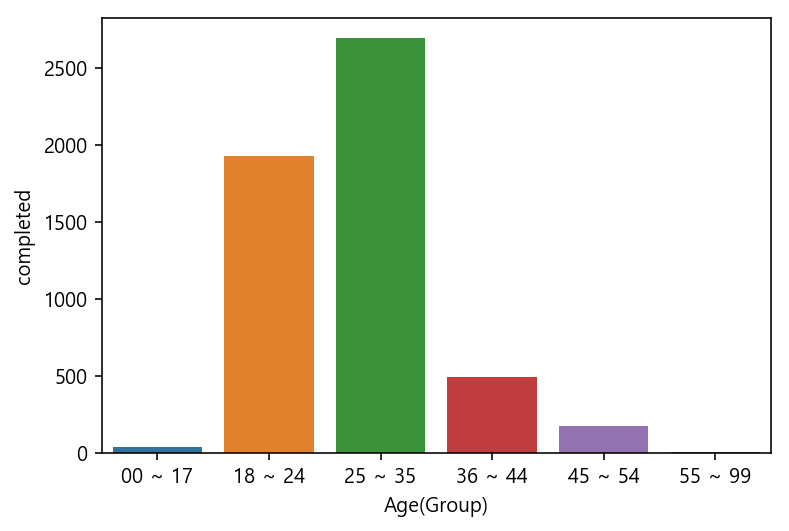

In [30]:
# Age(Group) pivot_table에서 completed 시각화 확인.
sns.barplot(data=table, x=table.index, y='completed', order=table.index)

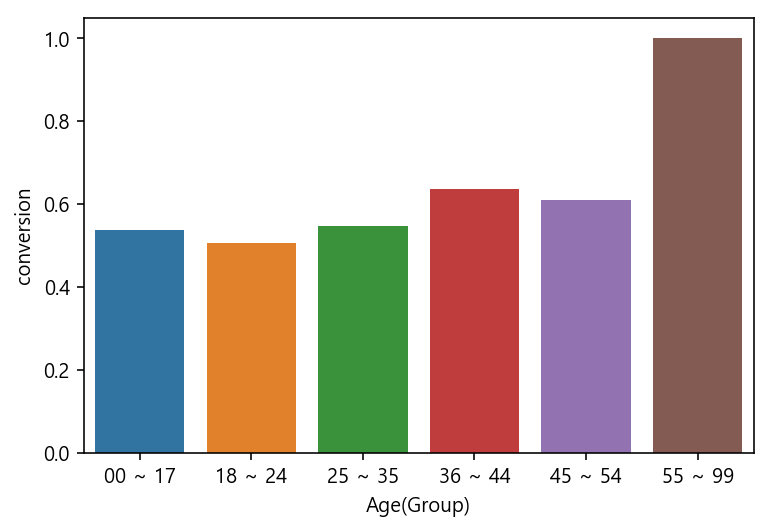

In [31]:
# Age(Group) pivot_table에서 conversion 시각화 확인.
sns.barplot(data=table, x=table.index, y='conversion', order=table.index)

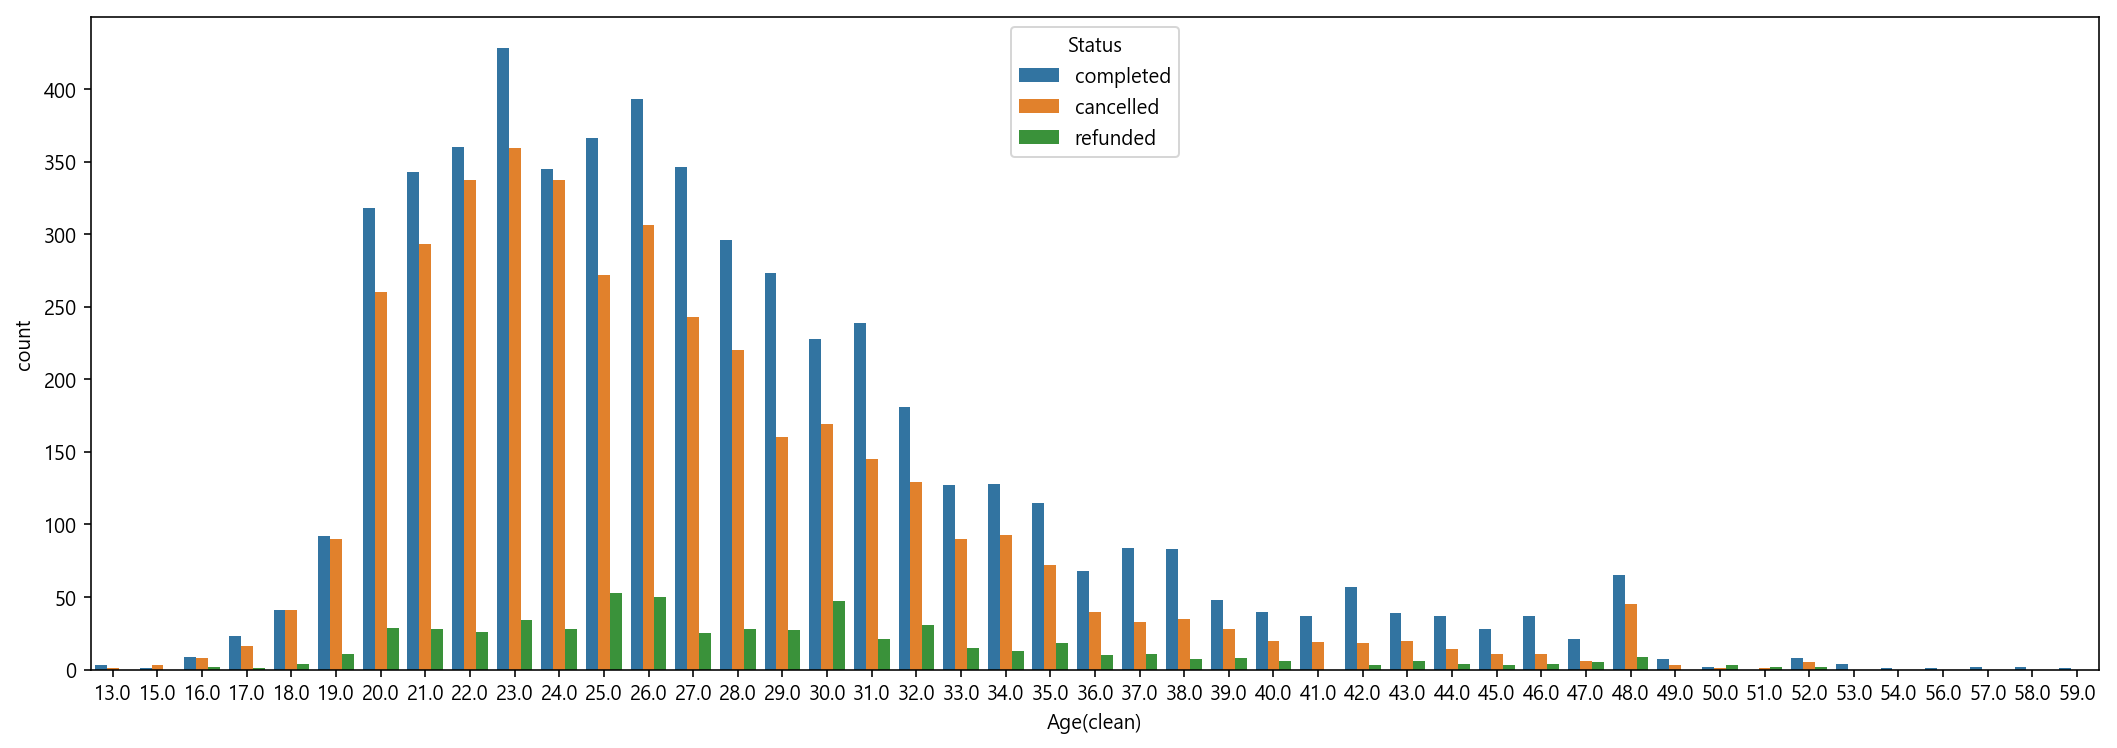

In [32]:
#Age(clean) data 에서 나이별 completed, cancelled, refunded 시각화 확인.
plt.figure(figsize=(18,6))
sns.countplot(data=data, x="Age(clean)", hue="Status")

* 위의 Age(Group)에서 확인 가능 하듯, 결제가 가능 많이 일어난 구간은 18 ~ 35 구간입니다. 
* conversion rate은 55 ~ 99 구간이 더 높지만, pivot_table 수치상 total이 18 ~35 구간이 앞도적으로 높습니다. 
* Age(clean)에서 결제, 취소, 환불 시각화를 보면, 확연히 18 살에서 완만히 높아 지다가, 20대 구간에 최고점을 찍고, 35살 까지 완만히 내려가는 형태입니다.

이 자료를 통해, 18 ~ 35살 구간이 전략적 마케팅 광고 구간임을 알 수 있습니다.

**5.5 Weekday and Time(completed/cancelled/refunded)**

시간 정보를 기준으로 결제/캔슬/환불 비율 확인.

  1. 시간별 구매 현황(0시 ~ 23시) 사이의 결제/캔슬/환불 비율
  2. 요일별 구매 현황(월요일 ~ 일요일) 사이의 결제/캔슬/환불 비율
  
마케팅팀이 이 정보를 파악할 수 있다면, 1) 전환율이 높은 시기에 마케팅 예산 투입 비중을 줄이고/늘려서 CAC를 낮추거나, 2) 특정 시간대에 눔 코치의 유료 서비스를 아직 구매하지 않은 무료 사용자에게 유료 서비스 구매를 유도하는 메일을 보내서 매출을 늘릴 것입니다.

In [33]:
# 구매 시기(Purchase datetime) 컬럼에서 시간(hour) 정보를 가져옵니다.
# 이 정보를 Purchase datetime(hour) 라는 이름의 새로운 컬럼에 할당.

data["Purchased At(hour)"] = data["Purchased At"].dt.hour

# data 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)

data[["Purchased At", "Purchased At(hour)"]].head()

(10000, 16)


,Purchased At,Purchased At(hour)
Access Code,,
Y9RY2VSI,2017-04-14 19:03:29.976,19
3GTN3S3B,2017-05-23 20:53:54.368,20
6B0IG276,2017-08-23 23:39:21.840,23
EMGRU2MO,2017-08-28 20:18:22.824,20
1ELG96TX,2017-05-07 17:50:30.944,17


In [34]:
# pandas의 pivot_table을 사용
# index에는 Purchase datetime(hour)을 넣어주고,
# Columns에는 Status를 넣어줌.
# aggfunc에 len을 넣어주면 cancelled, completed, refunded의 누적 개수 확인.
table = pd.pivot_table(data,
                      index = "Purchased At(hour)",
                      columns = "Status",
                      values = "Name",
                      fill_value = 0,
                      aggfunc = len)

# completed, cancelled, refunded의 총 인원 수를 더해서 total이라는 컬럼을 추가
table["total"] = table["completed"] + table["cancelled"] + table["refunded"]

# 추가한 total컬럼으로 completed컬럼을 나누면 결제 확률, Conversion이 나옴.
table["conversion"] = table["completed"] / table["total"]

# table데이터프레임의 결과를 출력
table

Status,cancelled,completed,refunded,total,conversion
Purchased At(hour),,,,,
0,236,344,26,606,0.567657
1,156,207,28,391,0.529412
2,90,97,4,191,0.507853
3,58,66,5,129,0.511628
4,59,45,7,111,0.405405
5,36,47,6,89,0.528090
6,48,70,6,124,0.564516
7,80,114,20,214,0.532710
8,171,264,29,464,0.568966


* 5.5.1 Visualization(Weekday and Time)
시각화를 통해 분석하는 것도 가능

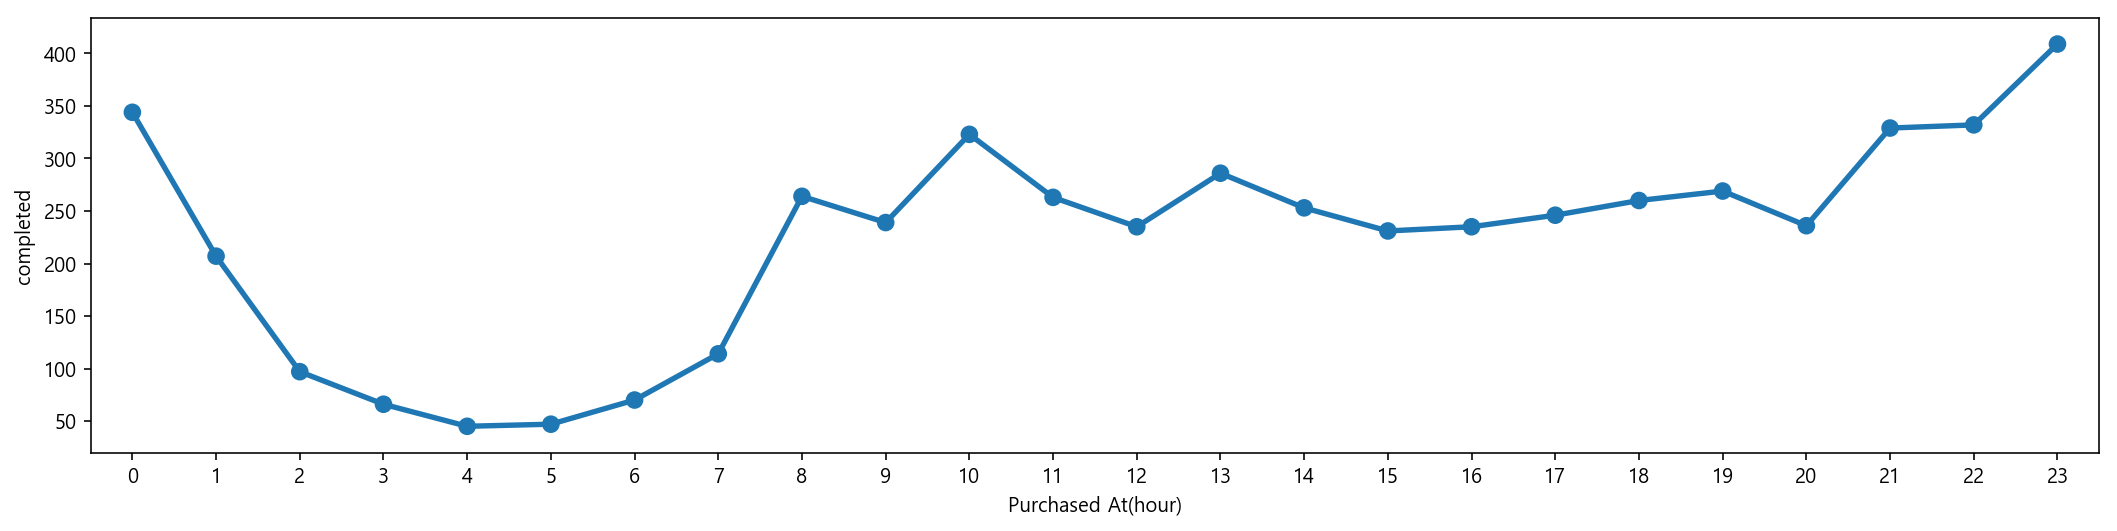

In [35]:
# Purchased At(hour) 시간 별, 결제(completed) 를 시각화.
# matplotlib의 subplots를 사용.
figure, ax = plt.subplots(nrows=1, ncols=1)

# 가로 18인치, 세로 4인치로 조절.
figure.set_size_inches(18, 4)

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화.
# X축은 구매 시간(Purchased At(hour))을, y축은 구매 완료 횟수 측정.
sns.pointplot(data=table.reset_index(), x="Purchased At(hour)", y="completed", ax=ax)

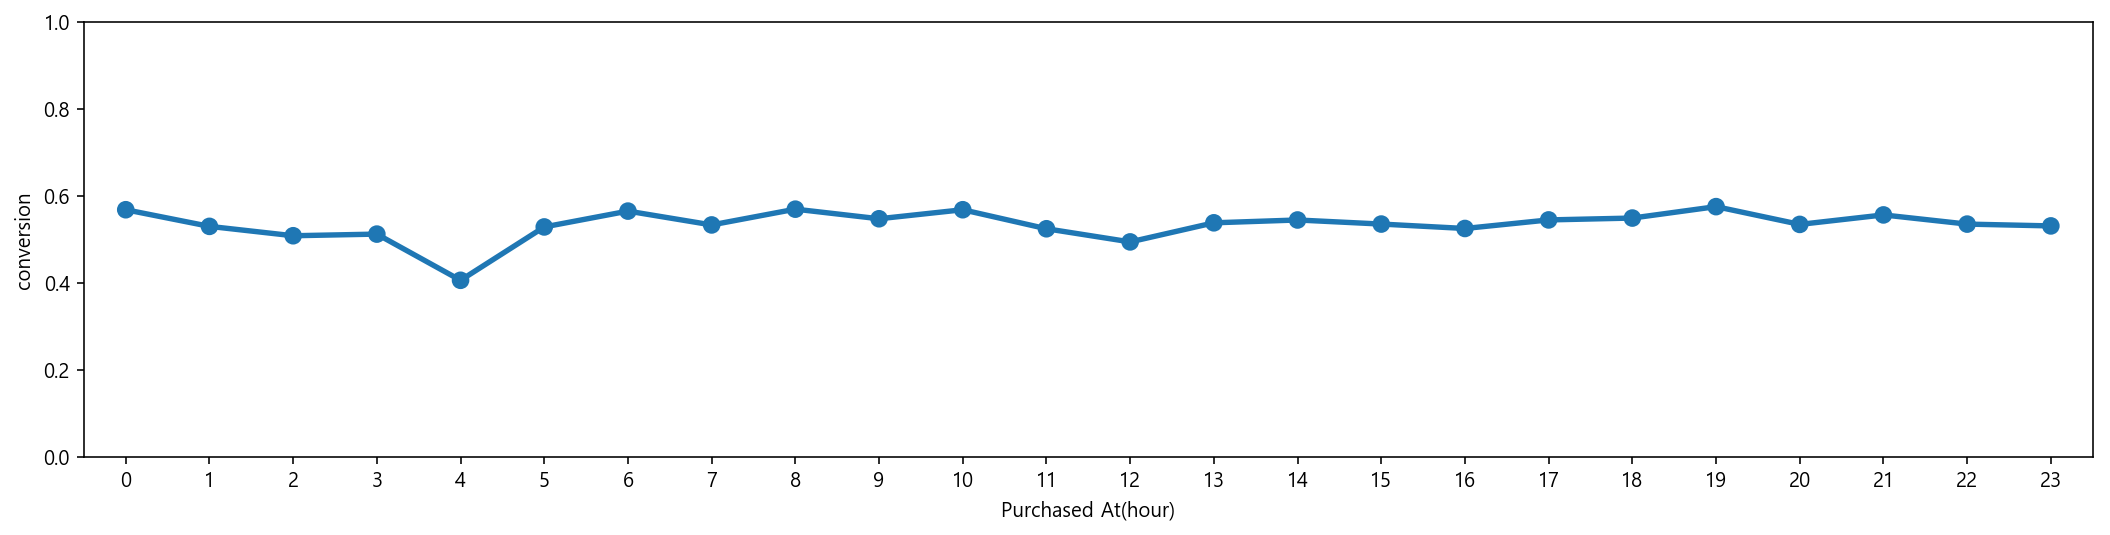

In [36]:
# matplotlib의 subplots를 사용. 이 기능을 사용 시각화의 가로X세로 사이즈 조절.
figure, ax = plt.subplots(nrows=1, ncols=1)

# 가로를 18인치, 세로를 4인치로 조절.
figure.set_size_inches(18, 4)

# y축의 최소/최대값을 0/1로 고정.
plt.ylim(0, 1)

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화.
# X축은 Purchased At(hour)을, y축은 conversion을 측정.
sns.pointplot(data=table.reset_index(), x="Purchased At(hour)", y="conversion", ax=ax)

분석 결과

  * 아쉽게도, 구매 시간별 전환율(conversion)은 큰 차이가 없어 보입니다, 그 의미는 특정 시간대에 구매한 사용자들이 서비스를 이탈할 확률이 높아지거나 낮아지는 현상은 없다고 볼 수 있습니다.
  * 다만 전환율과는 별개로, 주로 점심시간(10시 ~ 12시)나 새벽(23시 ~ 24시)에 구매량이 대폭 늘어난다는 것을 알 수 있습니다. 만일 광고 예산을 집행한다면 이 시기에 집중적으로 집행하거나, 무료 사용자에게 유료 사용자로 전환을 유도하는 이메일을 보냄으로써 전환율을 높이는 것은 시도해볼만 합니다.

월요일-일요일 사이의 결제/캔슬/환불 비율은 다음의 방식으로 구할 수 있습니다.

In [37]:
# Purchase datetime 컬럼에서 weekday 정보 불러옴.
# 정보를 Purchase datetime(weekday) 새로운 컬럼에 할당.
data["Purchased At(weekday)"] = data["Purchased At"].dt.weekday_name

# data 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)

# Purchase datetime와 Purchase datetime(weekday) 컬럼 찾은 뒤
# .head()로 상위 5개만 출력.
data[["Purchased At", "Purchased At(weekday)"]].head()

(10000, 17)


,Purchased At,Purchased At(weekday)
Access Code,,
Y9RY2VSI,2017-04-14 19:03:29.976,Friday
3GTN3S3B,2017-05-23 20:53:54.368,Tuesday
6B0IG276,2017-08-23 23:39:21.840,Wednesday
EMGRU2MO,2017-08-28 20:18:22.824,Monday
1ELG96TX,2017-05-07 17:50:30.944,Sunday


In [38]:
# pandas의 pivot_table을 사용.
# index에는 Purchase datetime(weekday)을 넣어주고,
# Columns에는 Status를 넣어줍니다.
# 그리고 aggfunc에 len을 넣어주면 cancelled, completed, refunded의 누적 개수 나옴.
table = pd.pivot_table(data,
                      index = "Purchased At(weekday)",
                      columns = "Status",
                      values = "Name",
                      fill_value = 0,
                      aggfunc = len)

# completed, cancelled, refunded의 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가
table["total"] = table["completed"] + table["cancelled"] + table["refunded"]

# 위에서 추가한 total 컬럼으로 completed 컬럼을 나누면 결제 확률, Conversion이 나옵니다.
table["conversion"] = table["completed"] / table["total"]

weekday_col = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# 이 데이터프레임의 결과를 월요일(Monday)부터 일요일(Sunday)까지 출력합니다.
table.loc[weekday_col]

Status,cancelled,completed,refunded,total,conversion
Purchased At(weekday),,,,,
Monday,691,863,93,1647,0.523983
Tuesday,694,935,102,1731,0.540150
Wednesday,679,953,90,1722,0.553426
Thursday,616,813,88,1517,0.535926
Friday,490,674,56,1220,0.552459
Saturday,412,537,73,1022,0.525440
Sunday,428,625,88,1141,0.547765


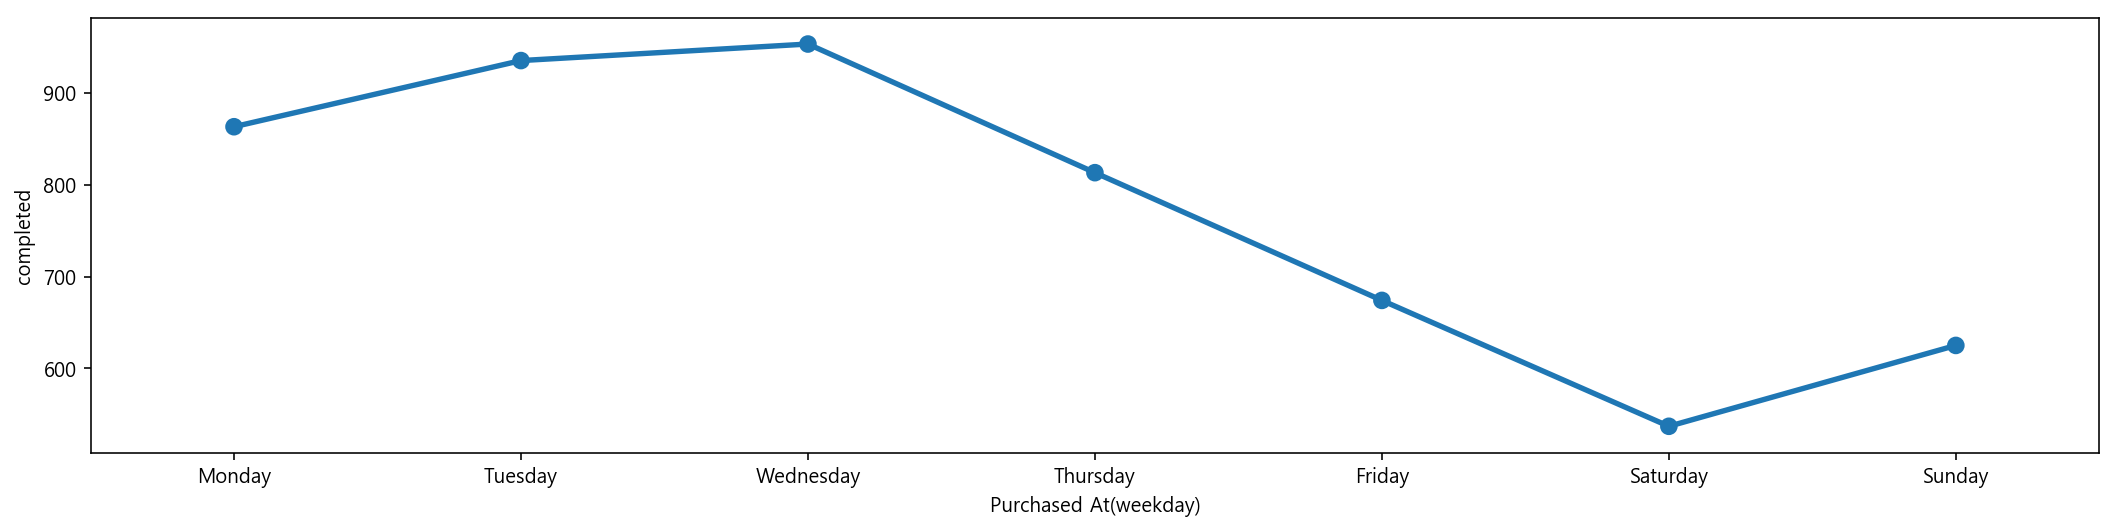

In [39]:
# matplotlib의 subplots를 사용합니다. 이 기능을 사용하면 시각화의 가로X세로 사이즈를 조절할 수 있습니다.
figure, ax = plt.subplots(nrows=1, ncols=1)

# 가로를 18인치, 세로를 4인치로 조절합니다.
figure.set_size_inches(18, 4)

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화합니다.
# X축은 구매 요일(Purchased At(weekday))을, y축은 구매 완료 횟수를 측정합니다.
sns.pointplot(data=table.reset_index(), x="Purchased At(weekday)", y="completed", order=weekday_col, ax=ax)

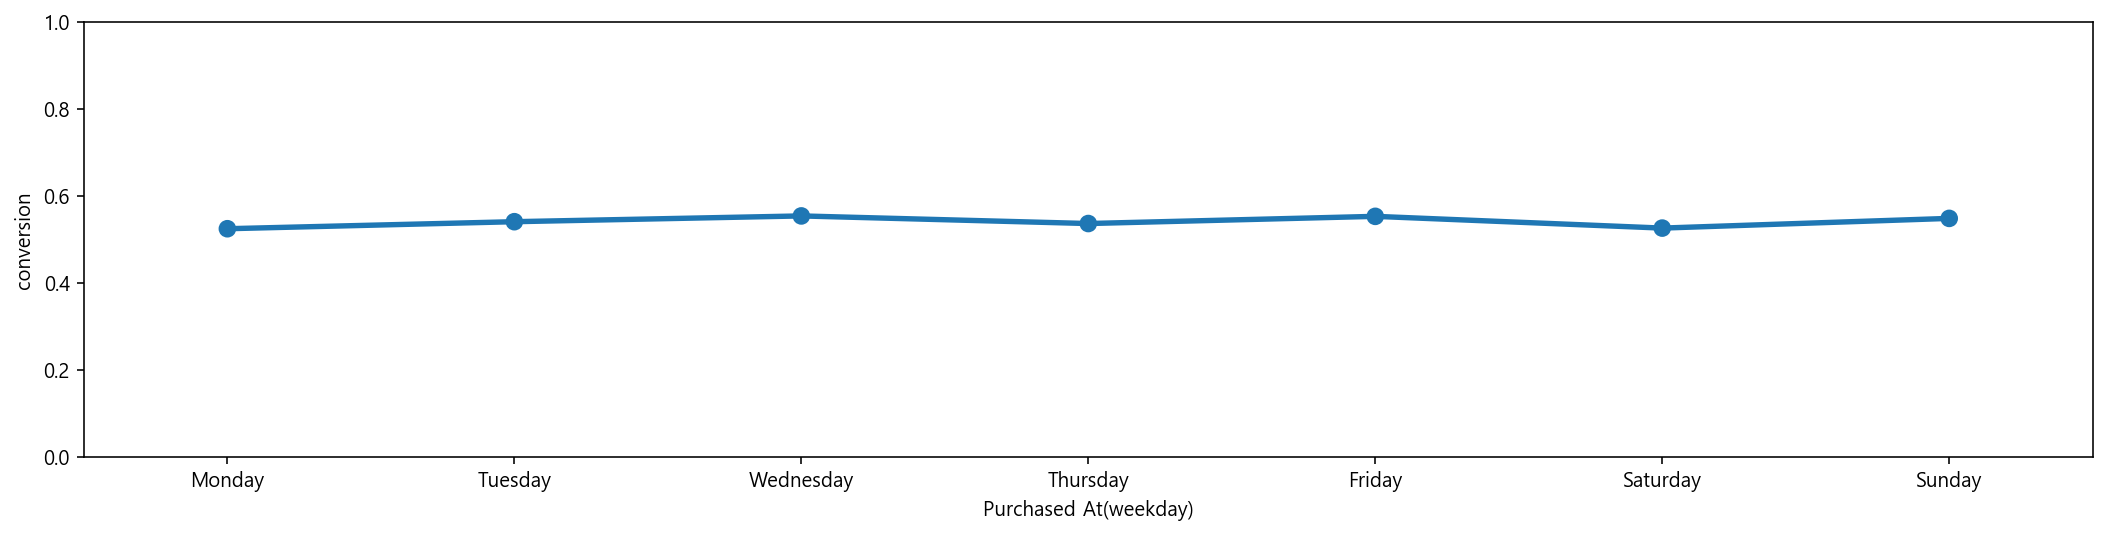

In [40]:
# matplotlib의 subplots를 사용합니다. 이 기능을 사용하면 시각화의 가로X세로 사이즈를 조절할 수 있습니다.
figure, ax = plt.subplots(nrows=1, ncols=1)

# 가로를 18인치, 세로를 4인치로 조절합니다.
figure.set_size_inches(18, 4)

# y축의 최소/최대값을 0/1로 고정합니다.
plt.ylim(0, 1)

# 이전에 피벗테이블로 분석한 결과를 pointplot으로 시각화합니다.
# X축은 구매 요일(Purchased At(weekday))을, y축은 전환율(conversion)을 측정합니다.
sns.pointplot(data=table.reset_index(), x="Purchased At(weekday)", y="conversion", order=weekday_col, ax=ax)

분석 결과

  * 구매 시간과 마찬가지로, 구매 요일별 전환율(conversion)은 큰 차이가 없어 보입니다. 어느 요일이나 마찬가지로, 구매한 사람이 서비스를 이탈하거나 남을 확률은 거의 동일합니다.
  * 하지만 사용자들은 전반적으로 주말(금-일)이 다가올수록 구매를 덜 하게되고, 주중(월-수)이 다가올수록 구매를 많이 하게 되는 현상을 발견할 수 있습니다. 이 시기에 광고 예산을 크게 집행하거나, 구매를 유도하는 메일이나 모바일 노티피케이션을 보내는 것은 좋은 아이디어입니다.

**5.6 Channel(completed/cancelled/refunded) with Visualization**

마케팅 채널별 결제/캔슬/환불 비율을 알고 싶습니다. 현재 눔에서 눔코치를 위해 운영중인 마케팅 채널은 크게 다음과 같습니다.

In [41]:
# channel 데이터의 수 확인.
data["Channel"].value_counts()

facebook     6880
others       1390
naver        1009
direct        297
email         271
google        120
instagram      33
Name: Channel, dtype: int64

채널별 마케팅 효율 정보를 알 수 있다면, 마케팅 팀에서 마케팅 예산을 재조정하여 1) 마케팅 효율이 좋은 채널에 예산을 집중하고, 2) 반대로 마케팅 효율이 좋지 않은 채널에 예산을 빼는 재조정(rebalancing)을 할 수 있습니다.

In [42]:
# pandas의 pivot_table을 사용.
# index에는 그룹화한 마케팅 채널 (Channel)을 넣어주고,
# Columns에는 Status를 넣어줍니다.
# 그리고 aggfunc에 len을 넣어주면 cancelled, completed, refunded의 누적 개수가 나옴.
table = pd.pivot_table(data,
                      index = "Channel",
                      columns = "Status",
                      values = "Name",
                      fill_value = 0,
                      aggfunc = len)

# completed, cancelled, refunded의 총 인원 수를 더해서 total이라는 새로운 컬럼 추가.
table["total"] = table["completed"] + table["cancelled"] + table["refunded"]

# 추가한 total이라는 컬럼으로 completed 컬럼을 나누면 결제 확률, Conversion이 나옴.
table["conversion"] = table["completed"] / table["total"]

#출력
table

Status,cancelled,completed,refunded,total,conversion
Channel,,,,,
direct,119,169,9,297,0.569024
email,93,155,23,271,0.571956
facebook,2812,3654,414,6880,0.531105
google,42,66,12,120,0.550000
instagram,13,17,3,33,0.515152
naver,386,568,55,1009,0.562934
others,545,771,74,1390,0.554676


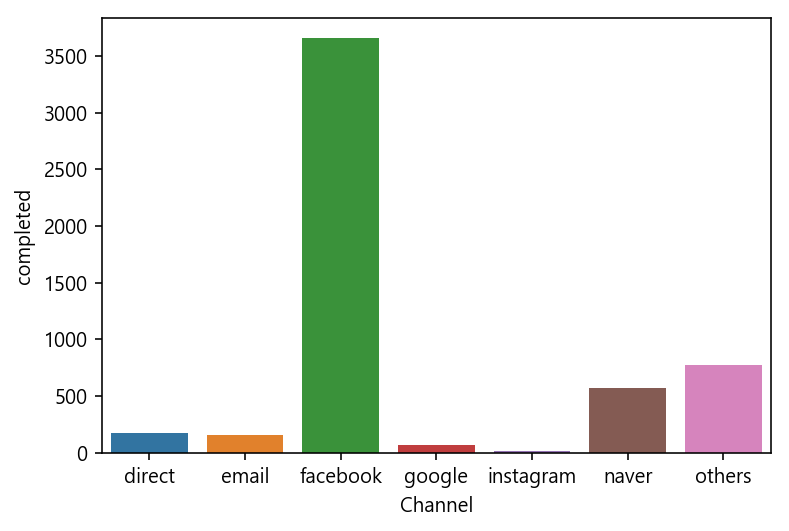

In [43]:
# channel 별 결제 현황 시각화
sns.barplot(data=table, x=table.index, y='completed', order=table.index)

이 결과를 통해 알 수 있는 정보는 다음과 같습니다.

  * 현재 가장 많은 구매가 일어나는 채널은 페이스북(facebook) 입니다. 거의 대부분의 구매가 이 채널에서 일어났습니다.
  * 구매량이 100회 이상인 채널 중 가장 전환율이 높은 채널은 이메일(email) 입니다. 이 채널은 사용자가 눔의 웹사이트에 방문한 뒤, 바로 구매하지 않고 이메일 주소만만 남겨놨을 경우에 해당됩니다.
  * 아직 구매량이 페이스북만큼 많지는 않지만, 전환률이 페이스북보다 높은 채널 중 하나는 네이버(naver)입니다. 전환율이 56%로 페이스북보다 다소 높은 편입니다.
  * 네이버만큼이나 전환율이 높은 채널은 기타(others)입니다. 이 채널은 결제율이 페이스북만큼 높음에도 불구하고, 아쉽게도 기록이 잘 되어있지 않기 때문에 분석이 어렵습니다.
  
이 분석 결과를 통해 얻을 수 있는 아이디어는 다음과 같습니다.
  
  * 먼저 내부에서 트래킹 코드나 데이터 클리닝 코드를 수정하여, 기타(others) 채널을 더 세분화시킬 필요가 있습니다. 기타 채널은 1) 페이스북 만큼이나 구매량이 많으며, 2) 전환율이 페이스북보다 높습니다. 이 채널을 더 세분화시켜 분석한다면 마케팅 효율을 높일 수 있는 새로운 아이디어가 나올 수 있습니다.
  * 페이스북 다음으로 네이버 검색채널을 집중적으로 튜닝하거나 예산을 배정하여 마케팅 채널을 다각화할 수 있습니다.
  * 이메일(email)로 들어온 사용자가 전환율이 높은 이유를 더 분석할 수 있다면 좋겠습니다. 추측컨데, 눔 코치에 대한 신뢰도를 높일 다양한 정보를 이메일로 수신하였기 때문에 다른 채널에 비해 전환율이 높다는 가설을 세울 수 있습니다. 이 가설이 맞다면, 눔 코치를 이용하는 다른 사용자에게도 동일한 정보를 제공한다면 전체 전환율을 높일 수 있을 것입니다.

#### 5.7 Gender(clean)과 Age(Group)의 Channel 별 completed 현황

In [44]:
# pandas의 pivot_table을 사용.
# index에는 그룹화한 Gender)clean, Age(Group), Channel을 넣어주고,
# Columns에는 Status를 넣어줍니다.
# 그리고 aggfunc에 len을 넣어주면 cancelled, completed, refunded의 누적 개수가 나옵니
table = pd.pivot_table(data,
                      index = ["Gender(clean)", "Age(Group)","Channel"],
                      columns = "Status",
                      values = "Name",
                      fill_value = 0,
                      aggfunc = len)

table["total"] = table["completed"] + table["cancelled"] + table["refunded"]

table["conversion"] = table["completed"] / table["total"]

# 출력
table

Status                              cancelled  completed  refunded  total  \
Gender(clean) Age(Group) Channel                                            
female        00 ~ 17    facebook          18         20         1     39   
                         google             2          0         0      2   
                         naver              1          4         2      7   
                         others             4         11         0     15   
              18 ~ 24    direct            40         37         2     79   
                         email             22         30         4     56   
                         facebook        1261       1394       109   2764   
                         google             7          8         5     20   
                         instagram          4          5         0      9   
                         naver            119        136        13    268   
                         others           184        217        16    417   
              25 ~ 35    direct            60         95         3    158   
                         email             43         71        11    125   
                         facebook        1141       1519       205   2865   
                         google             9         22         4     35   
                         instagram          7          7         3     17   
                         naver            188        287        16    491   
                         others           216        287        29    532   
              36 ~ 44    direct             5          5         1     11   
                         email             11         19         3     33   
                         facebook         115        246        32    393   
                         google             1          4         0      5   
                         instagram          2          3         0      5   
                         naver             29         49         7     85   
                         others            43         95         3    141   
              45 ~ 54    direct             1          0         1      2   
                         email              5         11         2     18   
                         facebook          46         82         8    136   
                         google             3         10         1     14   
                         naver              4         23         5     32   
                         others            15         34         8     57   
              55 ~ 99    direct             0          2         0      2   
                         facebook           0          1         0      1   
                         others             0          2         0      2   
male          00 ~ 17    facebook           1          1         0      2   
                         naver              2          0         0      2   
              18 ~ 24    direct             5         12         0     17   
                         email              1          0         1      2   
                         facebook          54         72        10    136   
                         google             3          2         0      5   
                         naver              8          1         0      9   
                         others             9         13         0     22   
              25 ~ 35    direct             8         11         2     21   
                         email              9         16         1     26   
                         facebook         129        235        33    397   
                         google            14         11         1     26   
                         naver             25         52         7     84   
                         others            50         79        13    142   
              36 ~ 44    direct             0          4         0      4   
                         email              1          4         0      5

위의 pivot_table 결과를 통해 알 수 있는 정보는,
* 성별, 나이별, 채널별 결제 현황과 conversion 입니다. Gender 통틀어 단연 Facebook에서 가장 많은 completed 가 이뤄지는 걸 다시 한번 확인 가능합니다. 
* 또한 전반적으로 남성 보다는 여서 이용자들이 많이 이용을 하며, 특히 여성 18~24, 그리고 25~35 나이 구간에서 conversion이 일어나는 걸 볼 수 있습니다.
* 다만 제가 가장 아쉬운건, 여성 00~17 구간의 고객층입니다. other에서 conversion이 가장 많이나오나, total 수치가 미비합니다.
* 학생 신분으로 부담되는 이용료 일수도 있다는 걸 가정하여, 학교 측과의 협약 혹은 공공기관과의 업무 협정으로, 학생들도 쉽게 접할수 있는  환경을 조성 하므로, 성인이 된 후에 첫 다이어트 프로그램을 눔과 함께 할 수 있게 마케킹 전략을 세울 수 있다고 생각됩니다.

#### 5.8 현 사용자의 Initial Weight으로 미래 고객층 마케팅 타켓 찾기. 

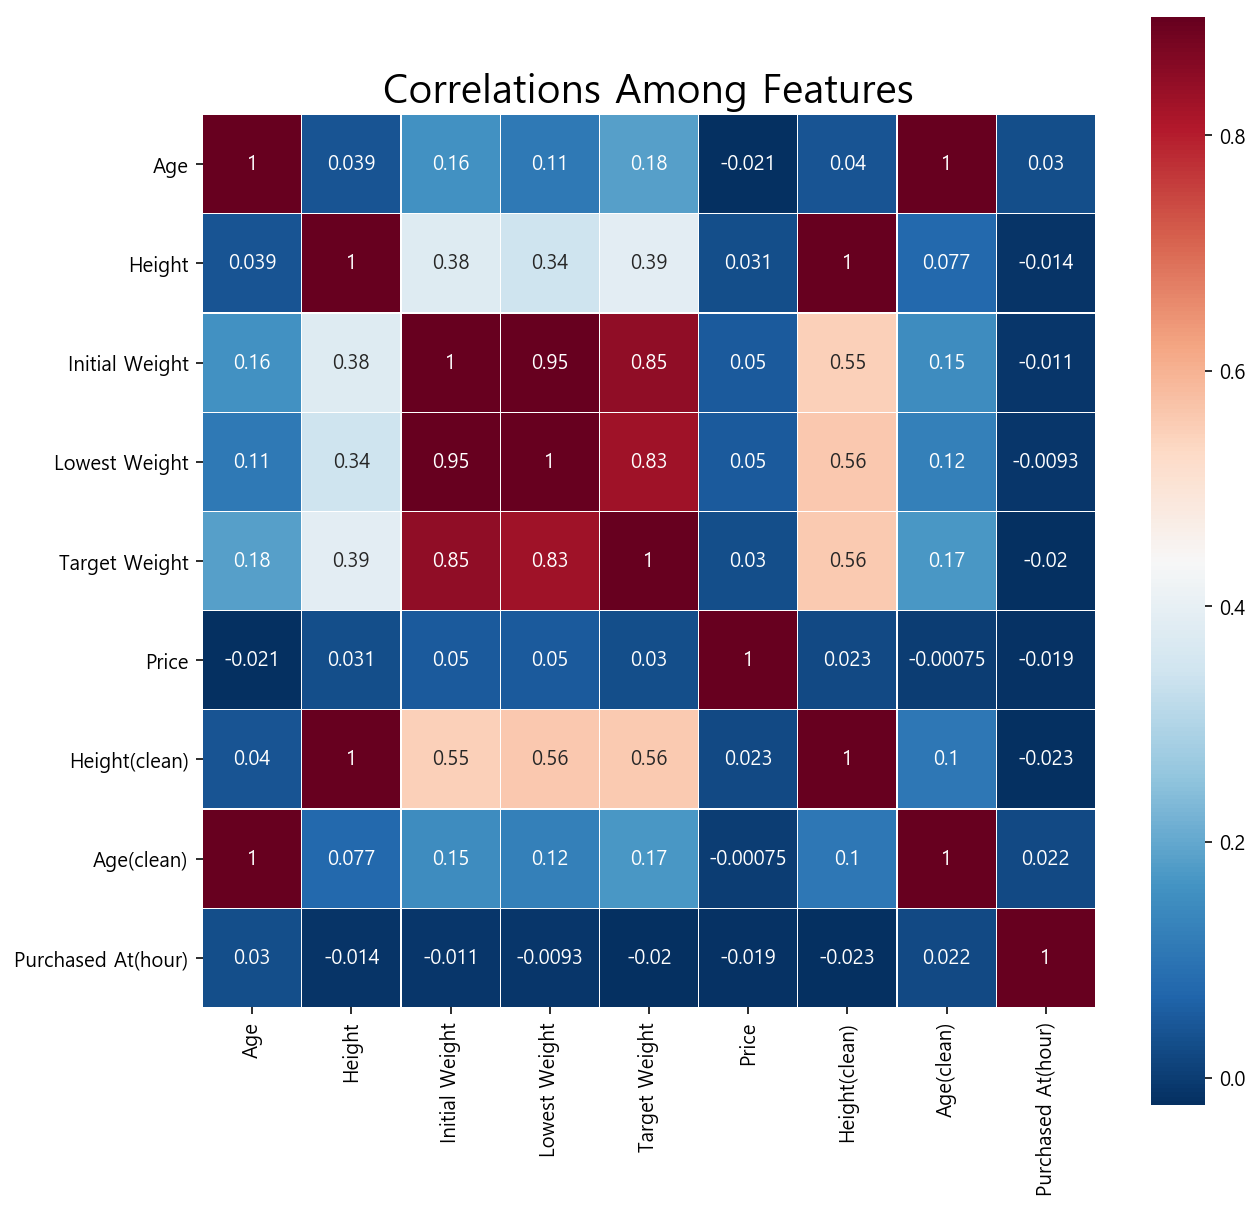

In [45]:
# heatmap으로 data의 서로의 연관성해 대해서 시작화 

mask = np.zeros_like(data.corr(), dtype=np.bool)

plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(), 
            annot=True,
            #mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

* 위 heatmap에서는 1에 가까 울수록 서로위 연관성이 높음을 뜻함.
* heatmap에서 확인 할 수 있듯이, 몸무게(Initial Weight, Lowest Weight, Target Weight)이 서로의 연관으로 강합니다.
* 위의 정보로 몸무게로 미래의 타겟 광고를 예측 할 수 있습니다.

In [46]:
# .describe()으로 바뀐 수치 확인.
data["Initial Weight"].describe()

count    9869.000000
mean       67.259726
std        13.789529
min        30.000000
25%        57.400000
50%        64.000000
75%        75.000000
max       153.000000
Name: Initial Weight, dtype: float64

In [47]:
# 0 값을 nan 값으로 새로운 Initial Weight(clean) 만듬.
data["Initial Weight(clean)"] = data["Initial Weight"]

#결측치로 여겨지는 마이너스 값을 nan 값으로 변경.
data.loc[data["Initial Weight(clean)"] == 0, "Initial Weight(clean)"] = np.nan

# 변경 확인
data.loc[data["Initial Weight"] == 0, ["Initial Weight", "Initial Weight(clean)"]].head()

,Initial Weight,Initial Weight(clean)
Access Code,,



이번에는 1) 성별(남자/여자), 2) Initial Weight(clean)에 따른 결제/캔슬/환불 비율 확인. 나이의 경우 그룹으로 설정 .

1. 35kg 이하
2. 36kg 이상, 45kg 이하
3. 46kg 이상, 55kg 이하
4. 56kg 이상, 65kg 이하
5. 66kg 이상, 75kg 이하
6. 76kg 이상, 85kg 이하
7. 86kg 이상, 95kg 이하
8. 96kg 이상, 99kg 이하
9. 99kg 이상, 130kg 이하
 * 몸무게통계학적 정보로 결제/캔슬/환불 비율을 확인하면, 마케팅팀에서는 가장 결제가 많이 일어나고 캔슬/환불이 적게 일어나는 성별과 몸무게에 마케팅 예산을 투입할 수 있습니다. (반대로 캔슬/환불이 빈번하게 일어나는 성별/몸무게에 해당하는 고객에는 마케팅 예산을 적게 집행할 것입니다)


In [60]:
# .loc() 사용하여 나이 Initial Weight(clean) 컬럼에서 나이 그룹 나눈 뒤, 새로운 컬럼인 Initial Weight(Group)으로 생성
data.loc[data["Initial Weight"] <= 35, "Initial Weight(Group)"] = "00 ~ 35kg"
data.loc[(data["Initial Weight"] >= 36) & (data["Initial Weight"] <= 45), "Initial Weight(Group)"] = "36 ~ 45kg"
data.loc[(data["Initial Weight"] >= 46) & (data["Initial Weight"] <= 55), "Initial Weight(Group)"] = "46 ~ 55kg"
data.loc[(data["Initial Weight"] >= 56) & (data["Initial Weight"] <= 65), "Initial Weight(Group)"] = "56 ~ 65kg"
data.loc[(data["Initial Weight"] >= 66) & (data["Initial Weight"] <= 75), "Initial Weight(Group)"] = "66 ~ 75kg"
data.loc[(data["Initial Weight"] >= 76) & (data["Initial Weight"] <= 85), "Initial Weight(Group)"] = "76 ~ 85kg"
data.loc[(data["Initial Weight"] >= 86) & (data["Initial Weight"] <= 95), "Initial Weight(Group)"] = "86 ~ 95kg"
data.loc[(data["Initial Weight"] >= 96) & (data["Initial Weight"] <= 99), "Initial Weight(Group)"] = "96 ~ 99kg"
data.loc[(data["Initial Weight"] >= 99) & (data["Initial Weight"] <= 130), "Initial Weight(Group)"] = "99 ~ 130kg"


# data 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data.shape)
data[["Initial Weight", "Initial Weight(Group)"]].head()

(10000, 19)


,Initial Weight,Initial Weight(Group)
Access Code,,
Y9RY2VSI,66.9,66 ~ 75kg
3GTN3S3B,70.0,66 ~ 75kg
6B0IG276,98.0,96 ~ 99kg
EMGRU2MO,70.7,66 ~ 75kg
1ELG96TX,55.5,NaN


In [61]:
# pivot_table로 Initial Weight(Group)을 성별로 구분 확인.
table = pd.pivot_table(data,
                      index =["Gender(clean)", "Initial Weight(Group)"],
                      columns = "Status",
                      values = "Name",
                      fill_value = 0,
                      aggfunc = "count"
                      )

# completed, cancelled, refunded의 총 인원 수를 더해서 total이라는 새로운 컬럼 추가.
table["total"] = table["completed"] + table["cancelled"] + table["refunded"]
#table["total"] = table[table["total"] >= 100]
# 추가한 total이라는 컬럼으로 completed 컬럼을 나누면 결제 확률, Conversion이 나옴.
table["conversion"] = table["completed"] / table["total"]

#출력
table

Status                               cancelled  completed  refunded  total  \
Gender(clean) Initial Weight(Group)                                          
female        00 ~ 35kg                      0          3         0      3   
              36 ~ 45kg                     21         29         2     52   
              46 ~ 55kg                    686        858        93   1637   
              56 ~ 65kg                   1421       1953       195   3569   
              66 ~ 75kg                    787       1005        92   1884   
              76 ~ 85kg                    359        446        51    856   
              86 ~ 95kg                    137        181        24    342   
              96 ~ 99kg                     19         16         2     37   
              99 ~ 130kg                    32         53         2     87   
male          00 ~ 35kg                      1          1         0      2   
              46 ~ 55kg                      0          1         0      1   
              56 ~ 65kg                      8          6         0     14   
              66 ~ 75kg                     44         58         7    109   
              76 ~ 85kg                    101        206        30    337   
              86 ~ 95kg                    109        164        17    290   
              96 ~ 99kg                     15         24         3     42   
              99 ~ 130kg                    61        111        17    189   

Status                               conversion  
Gender(clean) Initial Weight(Group)              
female        00 ~ 35kg                1.000000  
              36 ~ 45kg                0.557692  
              46 ~ 55kg                0.524130  
              56 ~ 65kg                0.547212  
              66 ~ 75kg                0.533439  
              76 ~ 85kg                0.521028  
              86 ~ 95kg                0.529240  
              96 ~ 99kg                0.432432  
              99 ~ 130kg               0.609195  
male          00 ~ 35kg                0.500000  
              46 ~ 55kg                1.000000  
              56 ~ 65kg                0.428571  
              66 ~ 75kg                0.532110  
              76 ~ 85kg                0.611276  
              86 ~ 95kg                0.565517  
              96 ~ 99kg                0.571429  
              99 ~ 130kg               0.587302

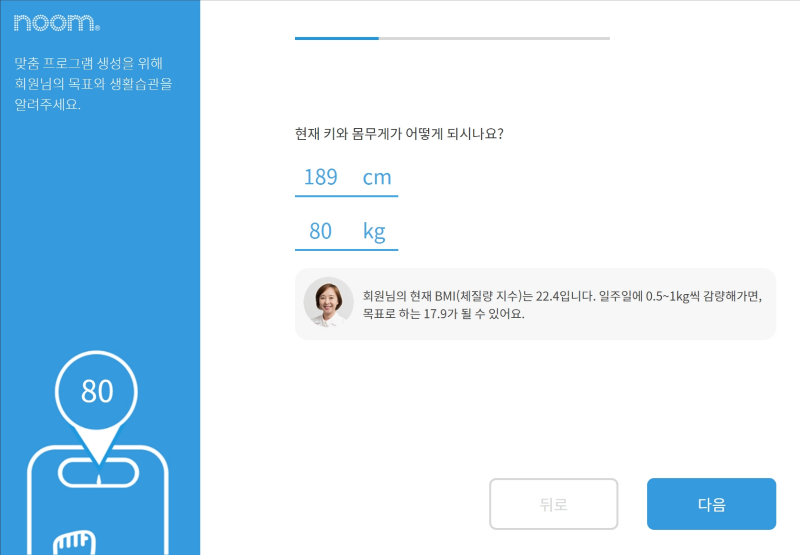

* 눔 코리아 최초 접속시 개인 프로필을 통한 다이어트 진단 정보를 기반으로 하여, 미래의 사용자에 대한 타겟 마케팅
* 개인 프로필 기입후, 먼저 이메일을 수직 후,다이어트 진단 정보를 이메일로 보내 준다면, 더 많은 이메일 마케팅 효과적 사용 가능 예상 
* 위의 성별/몸무게 기준으로 남성 보다는 여성이 사용량이 더 높고, 몸무게 구간 중 결제가 100개 이상 진행이된 구간(46 ~ 55kg, 56 ~ 65kg, 66 ~ 75kg, 76 ~ 85kg, 86 ~ 95kg)에 마케팅을 더 집중적으로 한다면, 고객 층 확보에 도움이 될것입니다.	

## 6. Matching With Coach Data

사용자 데이터와 코치 데이터를 합쳐서 분석. 코치 데이터 분석에서 가장 중요한 것은, 좋은 코칭 하는 사람과 그렇지 못한 사람을 구분.

코칭팀에서는 좋은 코칭을 하는 코치의 노하우를 정리하여 다른 코치들에게 전파할 필요가 있고, 정 반대로 좋지 않은 코칭을 하는 코치와는 개별 면담을 통해 코칭 퀄리티를 높여야 합니다. 좋은 코칭과 좋지 않은 코칭은 결제 비율과 캔슬 비율, 그리고 환불 비율로 판단 가능.

눔 코치 서비스의 코칭 만족도 분석.

In [50]:
# 먼저 코칭 데이터를 가져옵니다.
# coach라는 이름의 변수에 할당합니다.
coach = pd.read_csv("C:/Users/kyugs/Desktop/titanic/noom/transaction/transaction/noom_coach.csv", index_col="Access Code")

# coach 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(coach.shape)

# coach 데이터의 상위 5개를 출력.
coach.head()

(10000, 100)


,정은오 코치(VEV4PGJB),오승혁 코치(VENPKBP9),조소은 코치(D0WASBXN),고영재 코치(C91AVNGB),조수민 코치(OBCAO3W0),강채아 코치(WH2NIKCO),황다훈 코치(1I6IWURH),백슬은 코치(228BFB50),유채우 코치(IW53Y9AW),송지선 코치(WL0877P7),...,오초빈 코치(A3WOLAQM),서수정 코치(F36LORFC),정서율 코치(LX1G7EMD),고우재 코치(SKNL9Z4P),문한규 코치(OU1WVDGA),황세안 코치(3QUBQAVE),홍성은 코치(2I3QJQ5O),고성은 코치(34T7XPYR),백한율 코치(HPWAN8R0),안슬은 코치(QAVWJSZ1)
Access Code,,,,,,,,,,,,,,,,,,,,,
Y9RY2VSI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3GTN3S3B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6B0IG276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EMGRU2MO,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1ELG96TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


여기서 인덱스(index)는 눔 코치 사용자들의 아이디(```Access Code```), 열(column)은 코치들의 이름과 아이디(```Access Code```)입니다. 값은 코치가 사용자에게 코칭을 한 횟수를 나타냅니다. (한 명의 사용자가 여러 명의 코치에게 코칭을 받는 것도 가능합니다)

* **6.1 데이터 합치기(기존 + 코치).** 

먼저 기존 데이터와 코치 데이터를 하나로 합쳐야 분석을 할 수 있습니다.

In [51]:
# 전체 데이터에서 코치의 퍼포먼스를 체크하는데 필요한 데이터만을 가져옵니다.
# Name과 결제 여부(Status)만 있으면 충분.
# core_data라는 이름의 변수에 할당.
data_core = data[["Name", "Status"]]

# core_data 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
print(data_core.shape)

# core_data 데이터의 상위 5개를 출력
data_core.head()

(10000, 2)


,Name,Status
Access Code,,
Y9RY2VSI,김승혜,completed
3GTN3S3B,허승준,completed
6B0IG276,이지민,completed
EMGRU2MO,장설윤,completed
1ELG96TX,서성빈,completed


In [52]:
# 기존 데이터와 코치 데이터를 판다스의 concat로 합침.
# 이렇게 하면 인덱스에 해당하는 Access Code를 기준으로 하나로 합쳐집니다.
# data_coach 칼럼 이름의 새로운 데이터로 받습니다.
data_coach = pd.concat([data_core, coach], axis = 1)

# data_coach 변수에 할당된 데이터의 행렬 사이즈를 출력
print(data_coach.shape)

# 데이터의 상위 5개를 출력.
data_coach.head()

(10000, 102)


,Name,Status,정은오 코치(VEV4PGJB),오승혁 코치(VENPKBP9),조소은 코치(D0WASBXN),고영재 코치(C91AVNGB),조수민 코치(OBCAO3W0),강채아 코치(WH2NIKCO),황다훈 코치(1I6IWURH),백슬은 코치(228BFB50),...,오초빈 코치(A3WOLAQM),서수정 코치(F36LORFC),정서율 코치(LX1G7EMD),고우재 코치(SKNL9Z4P),문한규 코치(OU1WVDGA),황세안 코치(3QUBQAVE),홍성은 코치(2I3QJQ5O),고성은 코치(34T7XPYR),백한율 코치(HPWAN8R0),안슬은 코치(QAVWJSZ1)
Access Code,,,,,,,,,,,,,,,,,,,,,
Y9RY2VSI,김승혜,completed,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3GTN3S3B,허승준,completed,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6B0IG276,이지민,completed,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EMGRU2MO,장설윤,completed,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1ELG96TX,서성빈,completed,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **6.2 코치별 담당 Counts(total/coompleted/cancelled/refunded)**

이 수치를 통해 좋은 코칭을 하는 사람과 좋은 코칭을 하지 못하는 사람을 구분할 수 있습니다.

코치 별 cancelled, completed, refunded과 합계를 볼 수 있습니다.

In [53]:
tmp = data_coach.pivot_table(index='Status', aggfunc='sum', margins=True).T

tmp.head()

Status,cancelled,completed,refunded,All
강은우 코치(EJIHL7OE),122,171,16,309
강지희 코치(NOEP7X8B),15,19,1,35
강채아 코치(WH2NIKCO),9,10,2,21
고성은 코치(34T7XPYR),24,36,1,61
고수이 코치(NKHXTMRU),6,5,1,12


In [54]:
# 위와 같은 데이터를 보기 좋게 groupby를 사용 하여 적용.
# 코치의 코칭 데이터에서, 결제 상태(Status)를 기준으로 그룹핑한 다음에 전부 더합니다.
data_coach_perform = data_coach.groupby("Status").sum()

# data_coach_perform 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data_coach_perform.shape)

data_coach_perform.head()

(3, 100)


,정은오 코치(VEV4PGJB),오승혁 코치(VENPKBP9),조소은 코치(D0WASBXN),고영재 코치(C91AVNGB),조수민 코치(OBCAO3W0),강채아 코치(WH2NIKCO),황다훈 코치(1I6IWURH),백슬은 코치(228BFB50),유채우 코치(IW53Y9AW),송지선 코치(WL0877P7),...,오초빈 코치(A3WOLAQM),서수정 코치(F36LORFC),정서율 코치(LX1G7EMD),고우재 코치(SKNL9Z4P),문한규 코치(OU1WVDGA),황세안 코치(3QUBQAVE),홍성은 코치(2I3QJQ5O),고성은 코치(34T7XPYR),백한율 코치(HPWAN8R0),안슬은 코치(QAVWJSZ1)
Status,,,,,,,,,,,,,,,,,,,,,
cancelled,18,14,12,22,49,9,113,13,4,7,...,124,48,91,82,32,48,73,24,0,3
completed,23,44,12,27,46,10,155,10,2,18,...,150,53,125,96,33,61,112,36,1,5
refunded,3,9,1,4,8,2,24,2,0,1,...,27,2,15,11,2,8,9,1,0,1


In [55]:
# data_coach_perform 데이터를 전치(Transpose)합니다.
# 이렇게 하면 조금 더 보기에 편할 것 같습니다.

data_coach_perform = data_coach_perform.T

# data_coach_perform 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data_coach_perform.shape)

data_coach_perform.head()

(100, 3)


Status,cancelled,completed,refunded
정은오 코치(VEV4PGJB),18,23,3
오승혁 코치(VENPKBP9),14,44,9
조소은 코치(D0WASBXN),12,12,1
고영재 코치(C91AVNGB),22,27,4
조수민 코치(OBCAO3W0),49,46,8


* **6.3 코치별 Rate(conversion/cancellation)**

여기서 conversion은 전체 completed을 한 사람, cancelled은 전체 구매자 대비 취소(cancelled)나 환불(refunded)을 한 사람을 나타냅니다.  1) 전환율이 높은 코치, 2) 취소율이 높은 코치 순으로 정렬. 코칭을 100회 이상 하지 않은 사용자는 배제.

conversion이 높을수록 해당 코치가 고객에게 만족스러운 코칭을 제공한다고 볼 수 있으며, 해당 코치의 노하우를 다른 코치들에게 전파할 수 있도록 노력.

반면 취소율이 높을수록 해당 코치가 고객에게 만족스럽지 않은 코칭을 제공한다고 볼 수 있습니다. 이럴 경우 구체적으로 어떤 부분에서 문제가 생겼는지를 코칭팀에서 파악하여 이를 수정할 수 있어야 합니다.

<table border="1" class="dataframe" style="float: left;">
   <thead>
      <tr style="text-align: right;">
         <th>Status</th>
         <th>cancelled</th>
         <th>completed</th>
         <th>refunded</th>
         <th>total</th>
         <th>conversion rate</th>
         <th>cancellation rate</th>
      </tr>
   </thead>
   <tbody>
      <tr>
         <th>&#51312;&#49688;&#48124; &#53076;&#52824;(OBCAO3W0)</th>
         <td>49</td>
         <td>46</td>
         <td>8</td>
         <td>103</td>
         <td>0.446602</td>
         <td>0.553398</td>
      </tr>
      <tr>
         <th>&#48149;&#46020;&#50689; &#53076;&#52824;(I4KVQ5G0)</th>
         <td>77</td>
         <td>70</td>
         <td>6</td>
         <td>153</td>
         <td>0.457516</td>
         <td>0.542484</td>
      </tr>
      <tr>
         <th>&#50724;&#46041;&#50756; &#53076;&#52824;(0O48DQCH)</th>
         <td>55</td>
         <td>56</td>
         <td>7</td>
         <td>118</td>
         <td>0.474576</td>
         <td>0.525424</td>
      </tr>
      <tr>
         <th>&#51312;&#52488;&#50672; &#53076;&#52824;(3JBE9GKO)</th>
         <td>55</td>
         <td>56</td>
         <td>5</td>
         <td>116</td>
         <td>0.482759</td>
         <td>0.517241</td>
      </tr>
      <tr>
         <th>&#50724;&#52488;&#48712; &#53076;&#52824;(A3WOLAQM)</th>
         <td>124</td>
         <td>150</td>
         <td>27</td>
         <td>301</td>
         <td>0.498339</td>
         <td>0.501661</td>
      </tr>
   </tbody>
</table>

In [56]:
# completed, cancelled, refunded의 총 인원 수를 더해서 total이라는 새로운 컬럼을 추가.
data_coach_perform["total"] = data_coach_perform["completed"] + data_coach_perform["cancelled"] + data_coach_perform["refunded"]

# 추가한 total이라는 컬럼으로 completed컬럼을 나누면 구매 확률, conversion rate이 나옴.
data_coach_perform["conversion rate"] = data_coach_perform["completed"] / data_coach_perform["total"]

# cancelled 수 와 refunded 수 에 total을 나눠서 cancellation rate을 계산합니다.
data_coach_perform["cancellation rate"] = data_coach_perform["cancelled"] / data_coach_perform["total"]

# 결과를 출력
data_coach_perform.head()

Status,cancelled,completed,refunded,total,conversion rate,cancellation rate
정은오 코치(VEV4PGJB),18,23,3,44,0.522727,0.409091
오승혁 코치(VENPKBP9),14,44,9,67,0.656716,0.208955
조소은 코치(D0WASBXN),12,12,1,25,0.480000,0.480000
고영재 코치(C91AVNGB),22,27,4,53,0.509434,0.415094
조수민 코치(OBCAO3W0),49,46,8,103,0.446602,0.475728


In [62]:
# 모수가 적은 경우를 배제하기 위해, 최소 100명의 고객을 코칭한 코치만을 대상으로 계산. 
data_coach_perform_rate = data_coach_perform[data_coach_perform["total"] >= 100]

# data_coach_perform_rate 변수에 할당된 데이터의 행렬 사이즈를 출력.
print(data_coach_perform_rate.shape)

# 출력
data_coach_perform_rate.head()

(47, 6)


Status,cancelled,completed,refunded,total,conversion rate,cancellation rate
조수민 코치(OBCAO3W0),49,46,8,103,0.446602,0.475728
황다훈 코치(1I6IWURH),113,155,24,292,0.530822,0.386986
허성원 코치(9124O1IH),43,76,7,126,0.603175,0.341270
최서율 코치(UVZALFE3),139,164,25,328,0.500000,0.423780
윤채윤 코치(U95EGIDM),52,65,9,126,0.515873,0.412698


In [58]:
# conversion을 기준으로 가장 결제율이 높은 사람 상위 5개를 출력
data_coach_perform_rate.sort_values(by="conversion rate", ascending=False).head()

Status,cancelled,completed,refunded,total,conversion rate,cancellation rate
조우찬 코치(WWN531JQ),36,65,6,107,0.607477,0.336449
허슬지 코치(DWVG5IFL),43,71,3,117,0.606838,0.367521
허성원 코치(9124O1IH),43,76,7,126,0.603175,0.341270
조설영 코치(U7L98DAO),48,78,6,132,0.590909,0.363636
권슬영 코치(E3GD4106),42,70,9,121,0.578512,0.347107


In [59]:
# cancellation rate을 기준으로 가장 캔슬 비율이 낮은 사람 상위 5개를 출력.
data_coach_perform_rate.sort_values(by="cancellation rate", ascending=False).head()

Status,cancelled,completed,refunded,total,conversion rate,cancellation rate
박도영 코치(I4KVQ5G0),77,70,6,153,0.457516,0.503268
조수민 코치(OBCAO3W0),49,46,8,103,0.446602,0.475728
조초연 코치(3JBE9GKO),55,56,5,116,0.482759,0.474138
오동완 코치(0O48DQCH),55,56,7,118,0.474576,0.466102
서수정 코치(F36LORFC),48,53,2,103,0.514563,0.466019


이제 이 결과를 바탕으로, 고객에게 만족도를 높일 수 있도록 코칭을 개선할 수 있을 것입니다.
* 5.4 에서 언급했듯이, 여성 00 ~17 구간 total은 상대적으로 적지만, 앞으로 주요 고객이 될 타겟층이므로 교육청 및 시범학교 선정, 협업하여 데이터 축적 및 미래 사용자층을 확보 가능성 높일 기회로 만들수 있습니다.**"첫 다이어트는 눔과 함께"** 
* Diet의 어원은 고대 그리어에서 온거라 하는데, 그 뜻이 "A way of Life" 이라고 합니다. 다이어트는 더 이상 살을 빼는데 만 필요한게 아니라, 본 뜻대로 건강한 삶 자체 여야 한다고 생각 합니다.